In [3]:
import pandas as pd

In [4]:
import numpy as np

In [5]:
import geopandas as gpd

In [6]:
import matplotlib.pyplot as plt

In [7]:
from ast import literal_eval

In [8]:
from typing import Dict

In [9]:
pd.set_option('display.max_columns', None)

In [10]:
%load_ext autoreload

In [11]:
%autoreload
from logit_model import *

## Import

In [12]:
# Whole week
trips = pd.read_csv(
    r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP4 Performance Assessment Solution\Demand data\Matrices MITMA\with_archetypes\20220922_28_trip_matrix_arc_pt_processed.csv.gz",
    compression="gzip",
    sep="|"
)

In [13]:
trips = trips[trips["date"] == 20220923].reset_index(drop=True).rename(columns={"origin_nut": "origin", "destination_nut": "destination"})

In [12]:
trips_base = trips.copy()

**Demand**

In [12]:
# demand_all = pd.read_csv(r"C:/Users/Marine/Projects/MultiModX/data/example_strategic/es/pax_demand_all.csv")

# demand_path = r"C:/Users/Marine/Projects/MultiModX/data/example_strategic/es/pax_demand_partial.csv"
demand_path = r"C:/Users/Marine/Projects/MultiModX/data/es_full_AW/pax_demand_partial.csv"
demand_all = pd.read_csv(demand_path)

**Regions access**

In [13]:
# regions_access_path = r"C:/Users/Marine/Projects/MultiModX/data/example_strategic/es/regions_access_all.csv"
regions_access_path = r"C:/Users/Marine/Projects/MultiModX/data/es_full_AW/infrastructure/regions_access_all.csv"

regions_access_all = pd.read_csv(regions_access_path)

In [14]:
regions_access_all_luis = pd.read_csv(r"C:\Users\Marine\Projects\MultiModX\data\es_full_AW\infrastructure\regions_access_all_luis.csv")

In [15]:
stoptimes = pd.read_csv(r"C:\Users\Marine\Projects\MultiModX\data\es_full_AW\gtfs_es_20220708\stop_times.txt")

In [16]:
stops = pd.read_csv(r"C:\Users\Marine\Projects\MultiModX\data\es_full_AW\gtfs_es_20220708\stops.txt")

In [17]:
# possible_itineraries = pd.read_csv(
#     r"C:/Users/Marine/Projects/MultiModX/data/example_strategic/es/processed/possible_paths/possible_itineraries_0.csv"
# )
possible_itineraries = pd.read_csv(
    r"C:/Users/Marine/Projects/MultiModX/data/es_full_AW/processed/paths_itineraries/possible_itineraries_0.csv"
)
possible_itineraries = possible_itineraries[possible_itineraries["path"].notna()]

In [18]:
# potential_paths = pd.read_csv(
#     r"C:/Users/Marine/Projects/MultiModX/data/example_strategic/es/processed/possible_paths/potential_paths_0.csv"
# )
potential_paths = pd.read_csv(
    r"C:/Users/Marine/Projects/MultiModX/data/es_full_AW/processed/paths_itineraries/potential_paths_0.csv"
)

In [19]:
nuts3_ES_filtered = pd.read_csv("data/nuts3_ES_filtered.csv")

In [20]:
iata_icao = pd.read_csv("data/iata-icao.csv")

In [21]:
airports = pd.read_csv("data/airports.csv")

In [22]:
air_stops = pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP4 Performance Assessment Solution\Demand data\infrastructure_analysis/air_stops.txt")
rail_stops = pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP4 Performance Assessment Solution\Demand data\/infrastructure_analysis/train_stops.txt")

In [23]:
infra_filtered_path = r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP4 Performance Assessment Solution\Demand data\infrastructure_analysis\nuts3_ES_filtered.csv"
infra_no_filtered_path = r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP4 Performance Assessment Solution\Demand data\infrastructure_analysis\nuts3_ES_no_filtering.csv"
relation_iata_icao_path = r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP4 Performance Assessment Solution\Demand data\infrastructure_analysis\iata-icao.csv"

df_infra_filter = pd.read_csv(infra_filtered_path)
df_infra_all = pd.read_csv(infra_no_filtered_path)

In [24]:
air_rail_transitions_all = pd.read_csv(r"C:\Users\Marine\Projects\MultiModX\data\es_full_AW\infrastructure\air_rail_transitions_all.csv")

In [25]:
rail_stations_considered = pd.read_csv(
    r"C:/Users/Marine/Projects/MultiModX/data/es_full_AW/infrastructure/rail_stations_considered_luis.csv"
).astype(str)

## Format

In [26]:
possible_itineraries_reduced = possible_itineraries.drop_duplicates(["origin", "destination", "path"]).reset_index(drop=True)

**Replace name of airports by ICAO code**

In [27]:
airports["ICAO"] = airports["ICAO"].fillna(airports["IATA"])
iata_to_icao = airports.set_index("IATA")["ICAO"].to_dict()

**Replace NUT numbers that are deprecated**

In [ ]:
trips[trips["node_sequence_reduced"] != trips["node_sequence"]]

In [28]:
def replace_old_nut_codes(df: pd.DataFrame, col: str):
    old_nut_code_to_new = {"ES701": "ES707", "ES702": "ES709"}
    df[col] = df[col].replace(old_nut_code_to_new)

    return df

In [29]:
def assign_mode_tp(df: pd.DataFrame, mnd: bool = False):
    if mnd:
        df["mode_tp"] = df["mode_sequence"].apply(lambda row: [mode for mode in row.split("-") if mode != "road"])
    else:
        df["mode_tp"] = df.apply(
            lambda row: [row[f"mode_{i}"] for i in range(4) if str(row[f"mode_{i}"]) != "nan"], axis=1
        )
    return df

In [30]:
def format_trips(trips: pd.DataFrame):
    trips = (
        trips
        .pipe(replace_old_nut_codes, "origin")
        .pipe(replace_old_nut_codes, "destination")
        .pipe(assign_mode_tp, mnd=True)
    )
    trips = trips[~trips["mode_tp"].apply(lambda x: 'bus' in x or 'ship' in x)]

    return trips

In [31]:
def format_regions_access(regions_access: pd.DataFrame, iata_to_icao: Dict):
    regions_access = replace_old_nut_codes(regions_access, "region")
    regions_access["region_name"] = regions_access["region"].map(
        trips.drop_duplicates("origin").set_index("origin")["origin_name"]
    )
    regions_access["icao_station"] = regions_access["station"].map(iata_to_icao).fillna(regions_access["station"])
    return regions_access

In [32]:
def format_demand(demand: pd.DataFrame):
    demand = demand.pipe(replace_old_nut_codes, "origin").pipe(replace_old_nut_codes, "destination")

    return demand

In [33]:
def format_paths(paths: pd.DataFrame):
    paths = assign_mode_tp(paths)

    return paths

In [264]:
trips = format_trips(trips)

In [35]:
regions_access_all = format_regions_access(regions_access_all, iata_to_icao)

In [36]:
demand_all = format_demand(demand_all)

In [37]:
potential_paths = format_paths(potential_paths)

In [38]:
possible_itineraries_reduced = format_paths(possible_itineraries_reduced)

**Initialize pax demand using trips from MND**

**Read pickle files sensitivities**

In [1]:
import biogeme.results as res

In [244]:
read_results = res.bioResults(pickle_file=r"archetype_5.pickle")
print(read_results)


Results for model archetype_5
Nbr of parameters:		5
Sample size:			134
Excluded data:			0
Init log likelihood:		-147.214
Final log likelihood:		-65.66913
Likelihood ratio test (init):		163.0898
Rho square (init):			0.554
Rho bar square (init):			0.52
Akaike Information Criterion:	141.3383
Bayesian Information Criterion:	155.8275
Final gradient norm:		0.00640479
ASC_PLANE      : 16.3[128 0.127 0.899][2.1 7.74 1.04e-14]
ASC_TRAIN      : 15.5[128 0.121 0.904][0.548 28.2 0]
B_CO2          : -0.0889[0.0609 -1.46 0.144][0.0553 -1.61 0.108]
B_COST         : 0.0215[0.0282 0.763 0.446][0.0243 0.884 0.377]
B_TIME         : -0.00302[0.00147 -2.05 0.0403][0.00147 -2.05 0.0406]
('ASC_TRAIN', 'ASC_PLANE'):	1.63e+04	1	-0.409	0.683	0.878	0.761	-0.477	0.633
('B_CO2', 'ASC_PLANE'):	-0.0413	-0.00531	-0.128	0.898	-0.0265	-0.228	-7.73	1.09e-14
('B_CO2', 'ASC_TRAIN'):	-0.000125	-1.61e-05	-0.122	0.903	-0.000187	-0.00618	-28.2	0
('B_COST', 'ASC_PLANE'):	-0.0385	-0.0107	-0.127	0.899	-0.0269	-0.526	-7.68	1.62e

 ## Explore

**Number of origin, destination and OD pairs**

In [39]:
print(trips["origin"].nunique())
print(trips["destination"].nunique())

52
53


In [40]:
print(demand_all["origin"].nunique())
print(demand_all["destination"].nunique())

18
18


In [41]:
print(potential_paths["origin"].nunique())
print(potential_paths["destination"].nunique())

18
18


In [42]:
print(possible_itineraries_reduced["origin"].nunique())
print(possible_itineraries_reduced["destination"].nunique())

18
18


In [43]:
print(trips.drop_duplicates(["origin", "destination"]).shape[0])
print(potential_paths.drop_duplicates(["origin", "destination"]).shape[0])

1973
297


In [44]:
print(regions_access_all["region"].nunique())

51


In [45]:
set(trips["origin"]) - set(regions_access_all["region"].unique())

{'abroad'}

In [46]:
set(demand_all["origin"]) - set(regions_access_all["region"].unique())

set()

**Distribution of the number of legs**

In [47]:
(trips["train_legs"] + trips["plane_legs"]).mean()

np.float64(1.052954524506555)

In [48]:
(trips["train_legs"] + trips["plane_legs"]).value_counts()

1    216079
2     11452
3       305
4         1
Name: count, dtype: int64

In [49]:
(trips["train_legs"] + trips["plane_legs"]).value_counts()

1    216079
2     11452
3       305
4         1
Name: count, dtype: int64

In [50]:
(trips[(trips["train_legs"] != 0) & (trips["plane_legs"] != 0)]).shape[0] / trips.shape[0]

0.028630117145152015

In [51]:
(trips[(trips["train_legs"] != 0) & (trips["plane_legs"] != 0)])["trips"].sum() / trips["trips"].sum()

np.float64(0.024217271721623607)

**Mode sequence**

In [52]:
possible_itineraries_reduced["mode_tp"].value_counts()

mode_tp
[air, air]                  361
[air]                       349
[rail, rail]                220
[rail]                      131
[rail, rail, rail]          113
[air, air, air]              46
[rail, rail, rail, rail]     19
[air, rail]                  10
[air, rail, rail]             3
Name: count, dtype: int64

In [53]:
potential_paths["mode_tp"].value_counts()

mode_tp
[rail, rail, rail, rail]    809
[air, air]                  691
[rail, rail, rail, air]     690
[rail, rail, rail]          629
[rail, rail, air]           460
[rail, rail, air, air]      400
[rail, rail]                385
[air]                       357
[rail, air, air]            341
[rail, air]                 300
[air, air, air]             280
[air, rail, rail, rail]     247
[rail, air, air, air]       196
[air, rail, rail]           195
[rail]                      131
[air, rail]                  70
[air, air, rail, rail]       42
[air, air, rail]             26
[rail, air, rail, rail]       8
[air, air, air, air]          4
[air, rail, air]              4
[rail, air, rail]             4
Name: count, dtype: int64

In [54]:
trips["mode_tp"].value_counts().head(10)

mode_tp
[plane]                  109207
[train]                  106872
[plane, train]             3573
[train, plane]             2779
[plane, plane]             2777
[train, train]             2323
[plane, plane, plane]       112
[train, train, plane]        59
[plane, train, train]        50
[plane, plane, train]        27
Name: count, dtype: int64

In [55]:
trips["mode_tp"].value_counts()[:6].values.sum() / trips["mode_tp"].value_counts().values.sum()

np.float64(0.9986569345628673)

**Check if nodes exist twice in the same itinerary**

In [56]:
possible_itineraries["path"].apply(lambda r: any(r.count(x) > 1 for x in literal_eval(r))).sum()

np.int64(0)

**Nuts and list of stations**

In [57]:
def build_station_replacement_dict(relation_iata_icao_path: str, infra_no_filtered_path: str, infra_filtered_path: str):
    # Build IATA ICAO relation
    df_iata_icao = pd.read_csv(relation_iata_icao_path)
    df_iata_icao = df_iata_icao[df_iata_icao['country_code'] == 'ES']
    iata_icao_relation = df_iata_icao[['iata', 'icao']].set_index('icao').to_dict()
    iata_icao_relation['iata']['GCTS'] = 'TFS'
    iata_icao_relation['iata']['GCXO'] = 'TFN'
    iata_icao_relation['iata']['LERJ'] = 'RJL'

    # List all stations before filtering
    df_infra_all = pd.read_csv(infra_no_filtered_path)
    infra_to_nut = {}
    for index, row in df_infra_all.iterrows():
        nuts = row['NUTS_ID']
        
        if row['num_rail_stations'] == 0:
            pass
        else:
            for key in literal_eval(row['rail_stations']):
                infra_to_nut['train_{}'.format(key[0][2:] if len(key[0][2:]) == 5 else '0'+ key[0][2:])] = nuts

    # List all stations after filtering
    df_infra_filter = pd.read_csv(infra_filtered_path)
    nut_to_infra = {}
    for index, row in df_infra_filter.iterrows():
        nuts = row['NUTS_ID']
        nut_to_infra[nuts] = []
        
        if row['num_airports'] == 0:
            pass
        else:
            for key in literal_eval(row['airports']):
                infra_to_nut['airport_{}'.format(iata_icao_relation['iata'][key])] = nuts
        
        if row['num_rail_stations'] == 0:
            pass
        else:
            for key in literal_eval(row['rail_stations']):
                nut_to_infra[nuts] += ['train_{}'.format(key[0][2:])]
                
    infra_to_nut['airport_VIT'] = 'ES211'

    infra_to_nut_clean = {station.replace("train_", "").replace("airport_", "").lstrip("0"): value for station, value in infra_to_nut.items()}
    nut_to_infra_clean = {nut: [station.replace("train_", "") for station in stations] for nut, stations in nut_to_infra.items()}

    station_to_all_stations = {
        train_station: train_station if ((not train_station[0].isnumeric()) | (train_station in nut_to_infra_clean[nut]))
        else nut_to_infra_clean[nut][0] if nut_to_infra_clean[nut] else None
        for train_station, nut in infra_to_nut_clean.items()
    }

    return station_to_all_stations

In [58]:
station_to_all_stations = build_station_replacement_dict(relation_iata_icao_path, infra_no_filtered_path, infra_filtered_path)

**Replace stations that are not in rail stations considered --> should not be necessary anymore**

In [59]:
region_to_first_train_station = (regions_access_all_luis[regions_access_all_luis["layer"] == "rail"].drop_duplicates(
    "region"
).set_index("region")["station"].to_dict())

In [60]:
train_station_to_location_nut = {
    rail_station[0].lstrip("ES"): region for region, rail_stations in nuts3_ES_filtered[["NUTS_ID", "rail_stations"]].values
    if str(rail_stations) != "nan" for rail_station in literal_eval(rail_stations)
}

In [61]:
airport_to_location_nut = {
    airport: region for region, airports in nuts3_ES_filtered[["NUTS_ID", "airports"]].values
    if str(airports) != "nan" for airport in literal_eval(airports)
}

In [62]:
train_station_to_location_nut.update(airport_to_location_nut)

In [63]:
regions_access_all["location_nut"] = regions_access_all["station"].map(
    train_station_to_location_nut
)

In [64]:
station_to_luis_station = {
    station: station if ((station in regions_access_all_luis["station"].values) or (nut not in region_to_first_train_station))
    else region_to_first_train_station[nut] if region_to_first_train_station[nut] else None
    for station, nut in train_station_to_location_nut.items()
}

### Process

**Reduce itineraries to similar paths**

In [65]:
possible_itineraries["od_path"] = possible_itineraries["origin"] + "_" + possible_itineraries["destination"] + "__" + possible_itineraries["path"]

In [66]:
potential_paths["od_path"] = potential_paths["origin"] + "_" + potential_paths["destination"] + "__" + potential_paths["path"]

In [67]:
possible_paths_from_it = possible_itineraries.drop_duplicates("path").copy()

**Clean node sequence**

In [68]:
def complete_trips(trips: pd.DataFrame, stations_dict: Dict):
    trips["clean_node_sequence"] = (
        trips["node_sequence_reduced"].str.replace("train_", "")
        .str.replace("airport_", "")
    )
    trips["clean_start_node_old"] = (
        trips["start_node_reduced"].str.replace("train_", "")
        .str.replace("airport_", "")
    )
    trips["clean_end_node_old"] = (
        trips["end_node_reduced"].str.replace("train_", "")
        .str.replace("airport_", "")
    )

    trips["clean_start_node"] = (
       trips["clean_start_node_old"]
    ).map(stations_dict).fillna(trips["clean_start_node_old"])
    trips["clean_end_node"] = (
       trips["clean_end_node_old"]
    ).map(stations_dict).fillna(trips["clean_end_node_old"])
    
    trips["all_trips"] = trips.groupby(
        ["origin", "start_node_reduced", "clean_node_sequence", "end_node_reduced", "destination"]
    )["trips"].transform("sum")

    trips[
        ["archetype_0", "archetype_1", "archetype_2", "archetype_3", "archetype_4", "archetype_5"]
    ] = trips.groupby(
        ["origin", "start_node_reduced", "clean_node_sequence", "end_node_reduced", "destination"]
    )[["archetype_0", "archetype_1", "archetype_2", "archetype_3", "archetype_4", "archetype_5"]].transform("sum")

    return trips

In [69]:
def obtain_trips_reduced(trips: pd.DataFrame):
    trips_reduced = trips.drop_duplicates(
        ["origin", "start_node_reduced", "clean_node_sequence", "end_node_reduced", "destination"]
    ).drop(columns=["trips"]).rename(columns={"all_trips": "trips"}).reset_index(drop=True)

    return trips_reduced

In [70]:
def assign_path(trips: pd.DataFrame, iata_to_icao: Dict):
    trips["clean_node_sequence"] = trips["clean_node_sequence"].str.split("-")
    trips["clean_start_node"] = trips["clean_start_node"].map(iata_to_icao).fillna(
        trips["clean_start_node"]
    )
    
    trips["clean_end_node"] = trips["clean_end_node"].map(iata_to_icao).fillna(
        trips["clean_end_node"]
    )

    trips = trips.apply(apply_clean_node_sequence, axis=1)
    return trips

In [71]:
def apply_clean_node_sequence(row: pd.DataFrame):
    clean_node_sequence = row["clean_node_sequence"]

    origin_old, middle, destination_old = clean_node_sequence[0], clean_node_sequence[1:-1], clean_node_sequence[-1]

    middle = [x.lstrip("0") for x in middle]
    origin_clean, destination_clean = row[["clean_start_node", "clean_end_node"]]

    clean_node_sequence = [origin_clean] + middle + [destination_clean]
    clean_node_sequence = str([iata_to_icao.get(i) if i in iata_to_icao else i for i in clean_node_sequence])
    
    row["path"] = clean_node_sequence 

    return row

In [72]:
trips = complete_trips(trips, station_to_luis_station)

In [73]:
trips_reduced = obtain_trips_reduced(trips)

In [74]:
trips_reduced = assign_path(trips_reduced, iata_to_icao)

In [75]:
trips_reduced.head()

,date,trip_period,origin_zone,origin,origin_name,destination_zone,destination,destination_name,entry_point,exit_point,origin_purpose,destination_purpose,distance,route_distance,duration,mode,service,legs,trip_vehicle_type,nationality,home_census,home_zone,overnight_census,income,age,sex,vehicle_type,short_professional_driver,trips_km,sample_trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,n_legs,mode_sequence,node_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,clean_node_sequence,clean_start_node_old,clean_end_node_old,clean_start_node,clean_end_node,trips,path
0,20220923,P00,01002,ES211,Álava,4802006,ES213,Vizcaya,NaN,NaN,NF,O,D04_[10000-50000),D04_[10000-50000),01-02,train,conv_unknown,P00*01002*01002*None*train_13121*00-01*road*No...,other,ES,2_48,4801303,2_48,I01_[10000-15000),A01_[25-45),male,passenger,False,139.516,1.0,23.027167,0.000000,14.681375,20.794583,2.496875,0.000000,3,road-train-road,train_13121-train_13200,train_13121,train_13200,national,2,1,0,train_13121-train_13200,train_13106,train_13200,[train],"[13121, 13200]",13106,13200,11208,13200,61.000,"['11208', '13200']"
1,20220923,P00,01009_AM,ES211,Álava,31010_AM,ES220,Navarra,NaN,NaN,O,H,D04_[10000-50000),D04_[10000-50000),00-01,train,conv_unknown,P00*01009_AM*01009_AM*None*train_11213*00-01*r...,other,ES,2_31,31010_AM,2_31,I01_[10000-15000),A01_[25-45),male,passenger,False,69.312,1.0,3.707857,0.000000,0.000000,0.494381,0.000000,0.988762,3,road-train-road,train_11213-train_11300,train_11213,train_11300,national,2,1,0,train_11213-train_11300,train_13106,train_11300,[train],"[11213, 11300]",13106,11300,11208,81202,5.191,"['11208', '81202']"
2,20220923,P00,01009_AM,ES211,Álava,abroad_208,abroad,abroad,NaN,ground_Fra_08,NF,NF,abroad,D05_[50000-inf),01-02,train,conv_unknown,P00*01009_AM*01009_AM*None*train_11213*00-01*r...,other,FR,NaN,NaN,NaN,NaN,NaN,NaN,passenger,False,309.588,1.0,2.797917,1.024037,0.876589,0.217958,0.319243,0.072256,3,road-train-road,train_11213-train_11600,train_11213,train_11600,international_D,2,1,0,train_11213-train_11600,train_11208,train_11511,[train],"[11213, 11600]",11208,11511,11208,11511,5.308,"['11208', '11511']"
3,20220923,P00,01036,ES211,Álava,4802006,ES213,Vizcaya,NaN,NaN,H,O,D04_[10000-50000),D04_[10000-50000),00-01,train,conv_unknown,P00*01036*01036*None*train_13106*00-01*road*No...,other,ES,2_01,01036,2_48,I02_[15000-inf),A02_[45-65),female,passenger,False,139.477,1.0,190.090667,0.000000,102.137500,192.370500,66.059333,0.000000,3,road-train-road,train_13106-train_13200,train_13106,train_13200,national,2,1,0,train_13106-train_13200,train_13106,train_13200,[train],"[13106, 13200]",13106,13200,11208,13200,550.658,"['11208', '13200']"
4,20220923,P00,0105902,ES211,Álava,09219,ES412,Burgos,NaN,NaN,O,NF,D04_[10000-50000),D04_[10000-50000),01-02,train,conv_unknown,P00*0105902*0105901*None*train_11208*00-01*roa...,other,ES,2_01,0105904,2_01,I02_[15000-inf),A02_[45-65),male,passenger,False,155.813,1.0,1267.114479,13.032010,41.313671,81.972811,66.713333,95.965696,3,road-train-road,train_11208-train_11200,train_11208,train_11200,national,2,1,0,train_11208-train_11200,train_11208,train_11200,[train],"[11208, 11200]",11208,11200,11208,11014,1566.112,"['11208', '11014']"


**OD path**

In [76]:
def assign_od_path(df: pd.DataFrame):
    df["od_path"] = df["origin"] + "_" + df["destination"] + "__" + df["path"]
    return df

In [77]:
possible_paths_from_it = assign_od_path(possible_paths_from_it)

In [78]:
possible_itineraries_reduced = assign_od_path(possible_itineraries_reduced)

In [79]:
potential_paths = assign_od_path(potential_paths)

In [80]:
trips_reduced = assign_od_path(trips_reduced)

In [81]:
def obtain_trips_small(trips: pd.DataFrame):
    trips["all_trips"] = trips.groupby("od_path")["trips"].transform("sum")
    trips[
        ["archetype_0", "archetype_1", "archetype_2", "archetype_3", "archetype_4", "archetype_5"]
    ] = trips.groupby(
        ["od_path"]
    )[["archetype_0", "archetype_1", "archetype_2", "archetype_3", "archetype_4", "archetype_5"]].transform("sum")
    trips_small = trips.drop_duplicates("od_path").drop(columns="trips").rename(columns={"all_trips": "trips"}).reset_index(drop=True)

    return trips_small

In [82]:
trips_small = obtain_trips_small(trips_reduced)

In [83]:
trips_reduced.shape

(27036, 58)

In [84]:
trips_small.shape

(10113, 57)

**Filter potential paths**

In [85]:
potential_paths[potential_paths["path"].isna()].reset_index(drop=True)

,origin,destination,option,nservices,path,total_travel_time,total_cost,total_emissions,total_waiting_time,nmodes,journey_type,access_time,egress_time,origin_0,destination_0,mode_0,travel_time_0,cost_0,emissions_0,origin_1,destination_1,mode_1,travel_time_1,mct_time_0_1,cost_1,emissions_1,origin_2,destination_2,mode_2,travel_time_2,mct_time_1_2,cost_2,emissions_2,origin_3,destination_3,mode_3,travel_time_3,mct_time_2_3,cost_3,emissions_3,mode_tp,od_path


In [86]:
potential_paths = potential_paths[~potential_paths["path"].isna()].reset_index(drop=True)

In [87]:
has_duplicates = potential_paths.apply(lambda row: (pd.Series(literal_eval(row["path"])).duplicated().sum() >= 1), axis=1)

In [88]:
potential_paths = potential_paths[~has_duplicates].reset_index(drop=True)

In [89]:
potential_paths = potential_paths.drop_duplicates("od_path").reset_index(drop=True)

**Check if start and end pairs of nut and station exist**

In [90]:
set_of_existing_pairs = set(
    pd.Series(zip(regions_access_all["region"], regions_access_all["icao_station"]))
)

In [91]:
trips_small["start_exists"] = pd.Series([
    a in set_of_existing_pairs for a in tuple(zip(
        trips_small["origin"], trips_small["clean_start_node"]
    ))
])
trips_small["end_exists"] = pd.Series([
    a in set_of_existing_pairs for a in tuple(zip(
        trips_small["destination"], trips_small["clean_end_node"]
    ))
])

**Assign path_id**

In [92]:
potential_paths["path_id"] = (
    "path_id_" + potential_paths["option"].astype(str) + "_" +
    potential_paths["origin"] + "_" + potential_paths["destination"]
)

In [93]:
possible_itineraries_reduced["path_id"] = (
    "path_id_" + possible_itineraries_reduced["option"].astype(str) + "_" +
    possible_itineraries_reduced["origin"] + "_" + possible_itineraries_reduced["destination"]
)

In [94]:
trips_small["path_id"] = trips_small["od_path"].map(potential_paths.set_index("od_path")["path_id"])

**Select covered OD pairs**

In [95]:
len(set(zip(potential_paths["origin"], potential_paths["destination"])))

297

In [96]:
len(set(zip(trips_small["origin"], trips_small["destination"])))

1973

In [97]:
common_ods = set(zip(potential_paths["origin"], potential_paths["destination"])).intersection(
    set(zip(trips_small["origin"], trips_small["destination"]))
)

In [98]:
trips_covered = trips_small[
    pd.Series(zip(trips_small["origin"], trips_small["destination"])).isin(common_ods)
].copy()

In [99]:
potential_paths_covered = potential_paths[
    pd.Series(zip(potential_paths["origin"], potential_paths["destination"])).isin(common_ods)
].copy()

**Share of existing pairs origin and start station in trips**

In [100]:
# Share of origin paths

pd.Series([
    a in set_of_existing_pairs for a in tuple(zip(
        trips_small["origin"], trips_small["clean_start_node"]
    ))
]).mean()

np.float64(0.6103035696628103)

In [101]:
# Share of origin trips

((pd.Series([
    a in set_of_existing_pairs for a in tuple(zip(
        trips_small["origin"], trips_small["clean_start_node"]
    ))
]) * trips_small["trips"]).sum()) / trips_small["trips"].sum()

np.float64(0.759330354378499)

In [102]:
# Share of destination paths

pd.Series([
    a in set_of_existing_pairs for a in tuple(zip(
        trips_small["destination"], trips_small["clean_end_node"]
    ))
]).mean()

np.float64(0.5795510728764957)

In [103]:
# Share of destination trips

((pd.Series([
    a in set_of_existing_pairs for a in tuple(zip(
        trips_small["destination"], trips_small["clean_end_node"]
    ))
]) * trips_small["trips"]).sum()) / trips_small["trips"].sum()

np.float64(0.7422473153061758)

In [104]:
# Share of origin and destination

pd.Series([
    (a in set_of_existing_pairs) and (b in set_of_existing_pairs)
    for (a, b) in pd.Series(zip(
        tuple(zip(trips_small["origin"], trips_small["clean_start_node"])),
        tuple(zip(trips_small["destination"], trips_small["clean_end_node"]))
    ))
]).mean()

np.float64(0.35014337980816773)

In [105]:
# Share of origin and destination trips

((pd.Series([
    (a in set_of_existing_pairs) and (b in set_of_existing_pairs)
    for (a, b) in pd.Series(zip(
        tuple(zip(trips_small["origin"], trips_small["clean_start_node"])),
        tuple(zip(trips_small["destination"], trips_small["clean_end_node"]))
    ))
]) * trips_small["trips"]).sum()) / trips_small["trips"].sum()

np.float64(0.519336870231756)

In [106]:
# Share of origin and destination trips WITHOUT ABROAD

trips_small_no_abroad = trips_small[
    (trips_small["origin"] != "abroad") &
    (trips_small["destination"] != "abroad")
]
((pd.Series([
    (a in set_of_existing_pairs) and (b in set_of_existing_pairs)
    for (a, b) in pd.Series(zip(
        tuple(zip(
            trips_small_no_abroad["origin"],
            trips_small_no_abroad["clean_start_node"]
        )),
        tuple(zip(
            trips_small_no_abroad["destination"],
            trips_small_no_abroad["clean_end_node"]
        ))
    ))
]) * trips_small["trips"]).sum()) / trips_small["trips"].sum()

np.float64(0.6223601318370665)

**Assign trips to paths**

In [107]:
path_to_trips = trips_small.groupby("od_path")["trips"].sum().to_dict()

In [108]:
possible_paths_from_it["num_trips"] = possible_paths_from_it["od_path"].map(path_to_trips)

In [109]:
potential_paths["num_trips"] = potential_paths["od_path"].map(path_to_trips)

In [110]:
possible_itineraries_reduced["num_trips"] = possible_itineraries_reduced["od_path"].map(path_to_trips)

In [111]:
possible_paths_from_it["num_trips"].isna().mean()

np.float64(0.6861219195849546)

In [112]:
potential_paths["num_trips"].isna().mean()

np.float64(0.9051416579223505)

In [113]:
possible_itineraries_reduced["num_trips"].isna().mean()

np.float64(0.6589456869009584)

In [114]:
trips["trips"].sum()

np.float64(915318.3419999997)

In [115]:
possible_paths_from_it["num_trips"].sum() / trips["trips"].sum()

np.float64(0.21302596818277247)

In [116]:
potential_paths["num_trips"].sum() / trips["trips"].sum()

np.float64(0.2338221175950171)

**Reassign small train stations**

In [117]:
def apply_new_node_sequence(row: pd.DataFrame):
    try:
        clean_node_sequence = literal_eval(row["path"])
    except:
        print(row.name)

    # clean_node_sequence = (row["clean_node_sequence"])
    origin, middle, destination = clean_node_sequence[0], clean_node_sequence[1:-1], clean_node_sequence[-1]

    new_middle = [station_to_all_stations[i] if i in station_to_all_stations else i for i in middle]
    new_middle = list(dict.fromkeys(new_middle))
    # print(clean_node_sequence, middle, new_middle)
    if origin not in new_middle:
        new_middle = [origin] + new_middle
    if destination not in new_middle:
        new_middle = new_middle + [destination]
    row["new_node_sequence"] = str(new_middle)

    return row

In [118]:
trips_small = trips_small.apply(apply_new_node_sequence, axis=1)

In [119]:
trips_small["od_path_new"] = trips_small["origin"] + "_" + trips_small["destination"] + "__" + trips_small["new_node_sequence"]

In [120]:
trips_small["path_id"] = trips_small["od_path"].map(potential_paths.set_index("od_path")["path_id"])
# trips_small["path_id"] = trips_small["od_path"].map(possible_itineraries_reduced.set_index("od_path")["path_id"])
trips_small["path_id_new"] = trips_small["od_path_new"].map(potential_paths.set_index("od_path")["path_id"])

In [121]:
trips_small[
    (trips_small["path_id"] != trips_small["path_id_new"]) &
    (trips_small["path_id"].notna())
]

,date,trip_period,origin_zone,origin,origin_name,destination_zone,destination,destination_name,entry_point,exit_point,origin_purpose,destination_purpose,distance,route_distance,duration,mode,service,legs,trip_vehicle_type,nationality,home_census,home_zone,overnight_census,income,age,sex,vehicle_type,short_professional_driver,trips_km,sample_trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,n_legs,mode_sequence,node_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,clean_node_sequence,clean_start_node_old,clean_end_node_old,clean_start_node,clean_end_node,path,od_path,trips,start_exists,end_exists,path_id,new_node_sequence,od_path_new,path_id_new


**Final assignment**

In [122]:
trips_covered = trips_small[
    pd.Series(zip(trips_small["origin"], trips_small["destination"])).isin(common_ods)
].copy()

In [123]:
trips_covered[
    (trips_covered["od_path"] != trips_covered["od_path_new"]) &
    (trips_covered["path_id"].notna())
]

,date,trip_period,origin_zone,origin,origin_name,destination_zone,destination,destination_name,entry_point,exit_point,origin_purpose,destination_purpose,distance,route_distance,duration,mode,service,legs,trip_vehicle_type,nationality,home_census,home_zone,overnight_census,income,age,sex,vehicle_type,short_professional_driver,trips_km,sample_trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,n_legs,mode_sequence,node_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,clean_node_sequence,clean_start_node_old,clean_end_node_old,clean_start_node,clean_end_node,path,od_path,trips,start_exists,end_exists,path_id,new_node_sequence,od_path_new,path_id_new


In [124]:
ods_trips = set(zip(trips["origin"], trips["destination"]))

In [125]:
print(len(common_ods))
print(len(ods_trips))

297
1973


**Assign % to each node sequence**

In [126]:
trips_covered["%_of_od"] = trips_covered.index.map(trips_covered.groupby(
    ["origin", "destination"]
).apply(lambda df: df["trips"] / df["trips"].sum()).reset_index().set_index("level_2")["trips"])
# trips_covered.groupby(["origin", "destination"])["trips"].transform("sum")

C:\Users\Marine\AppData\Local\Temp\ipykernel_12716\154538515.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(lambda df: df["trips"] / df["trips"].sum()).reset_index().set_index("level_2")["trips"])


### Explore proportion of assigned paths

In [127]:
print(trips_covered["path_id"].isna().mean())
print(trips_covered["path_id"].notna().mean())

0.7762376237623763
0.22376237623762377


In [128]:
def proportion_of_assigned_path(df: pd.DataFrame, path_col: str = "path_id"):
    assigned_path_travellers = (df["trips"] * df[path_col].notna()).sum()
    return assigned_path_travellers / df["trips"].sum()

In [129]:
proportion_of_assigned_path(trips_covered, "path_id")

np.float64(0.7301171203505255)

In [130]:
proportion_of_assigned_path(trips_covered, "path_id_new")

np.float64(0.7314460820942977)

In [131]:
trips_covered[trips_covered["path_id"].isna()].head()

,date,trip_period,origin_zone,origin,origin_name,destination_zone,destination,destination_name,entry_point,exit_point,origin_purpose,destination_purpose,distance,route_distance,duration,mode,service,legs,trip_vehicle_type,nationality,home_census,home_zone,overnight_census,income,age,sex,vehicle_type,short_professional_driver,trips_km,sample_trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,n_legs,mode_sequence,node_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,clean_node_sequence,clean_start_node_old,clean_end_node_old,clean_start_node,clean_end_node,path,od_path,trips,start_exists,end_exists,path_id,new_node_sequence,od_path_new,path_id_new,%_of_od
14,20220923,P00,0303103,ES521,Alicante / Alacant,08086,ES511,Barcelona,NaN,NaN,NF,NF,D05_[50000-inf),D05_[50000-inf),08-10,road,NaN,P00*0303103*43904*None*train_65402*03-04*road*...,other,ES,2_03,0301801,2_03,I01_[10000-15000),A02_[45-65),male,passenger,False,1741.160,1.0,42.540917,3.347530,3.736235,7.027446,10.225286,5.715586,3,road-train-road,train_65402-train_71801,train_65402,train_71801,national,2,1,0,train_65402-train_71801,train_65402,train_71801,[train],"[65402, 71801]",65402,71801,71500,71801,"['71500', '71801']","ES521_ES511__['71500', '71801']",72.593,False,True,NaN,"['71500', '71801']","ES521_ES511__['71500', '71801']",NaN,0.088145
19,20220923,P00,0306604,ES521,Alicante / Alacant,0801904,ES511,Barcelona,NaN,NaN,H,NF,D05_[50000-inf),D05_[50000-inf),06-08,train,conv_unknown,P00*0306604*0306601*None*train_60905*00-01*roa...,other,ES,2_03,0306604,2_03,I00_[0-10000),A00_[0-25),female,passenger,False,2018.875,1.0,176.887802,14.224238,15.241900,34.261585,40.447078,28.070396,3,road-train-road,train_60905-train_71801,train_60905,train_71801,national,2,1,0,train_60905-train_71801,train_60911,train_71801,[train],"[60905, 71801]",60911,71801,60911,71801,"['60911', '71801']","ES521_ES511__['60911', '71801']",309.133,True,True,NaN,"['60911', '71801']","ES521_ES511__['60911', '71801']",NaN,0.375360
20,20220923,P00,0306604,ES521,Alicante / Alacant,2807906,ES300,Madrid,NaN,NaN,NF,W,D05_[50000-inf),D05_[50000-inf),08-10,train,conv_unknown,P00*0306604*03140*None*train_03309*00-01*road*...,other,ES,2_28,2807901,2_03,I02_[15000-inf),A02_[45-65),male,passenger,False,1443.260,1.0,869.912655,33.448888,42.019362,159.815299,285.758336,67.691460,3,road-train-road,train_03309-train_17000,train_03309,train_17000,national,2,1,0,train_03309-train_17000,train_60902,train_17000,[train],"[03309, 17000]",60902,17000,60911,17000,"['60911', '17000']","ES521_ES300__['60911', '17000']",1458.646,True,True,NaN,"['60911', '17000']","ES521_ES300__['60911', '17000']",NaN,0.569061
23,20220923,P00,0309906,ES521,Alicante / Alacant,3003003,ES620,Murcia,NaN,NaN,NF,NF,D04_[10000-50000),D04_[10000-50000),00-01,train,conv_unknown,P00*0309906*30010*None*train_62001*00-01*road*...,other,ES,2_30,3003004,2_30,I01_[10000-15000),A00_[0-25),female,passenger,False,146.166,1.0,162.764239,4.785744,5.709340,26.118766,14.869632,18.694280,3,road-train-road,train_62001-train_61200,train_62001,train_61200,national,2,1,0,train_62001,train_61200,train_61200,[train],[62001],61200,61200,61200,61200,"['61200', '61200']","ES521_ES620__['61200', '61200']",232.942,False,True,NaN,['61200'],ES521_ES620__['61200'],NaN,0.074133
27,20220923,P00,03140,ES521,Alicante / Alacant,46145,ES523,Valencia / València,NaN,NaN,W,O,D04_[10000-50000),D05_[50000-inf),00-01,train,conv_unknown,P00*03140*03140*None*train_60902*00-01*road*No...,other,ES,2_03,03140,2_03,I00_[0-10000),A02_[45-65),female,passenger,False,305.513,1.0,1274.707410,45.174343,52.651486,138.194330,123.537002,157.943430,3,road-train-road,train_60902-train_64100,train_60902,train_64100,national,2,1,0,train_60902-train_64100,train_60902,train_65000,[train],"[60902, 64100]",60902,65000,60911,3216,"['60911', '3216']","ES521_ES523__['60911', '3216']",1792.208,True,True,NaN,"['60911', '321

In [132]:
assigned_paths_mean = trips_covered.groupby(["origin", "destination"])["path_id_new"].apply(lambda x: x.isnull().mean()).reset_index()

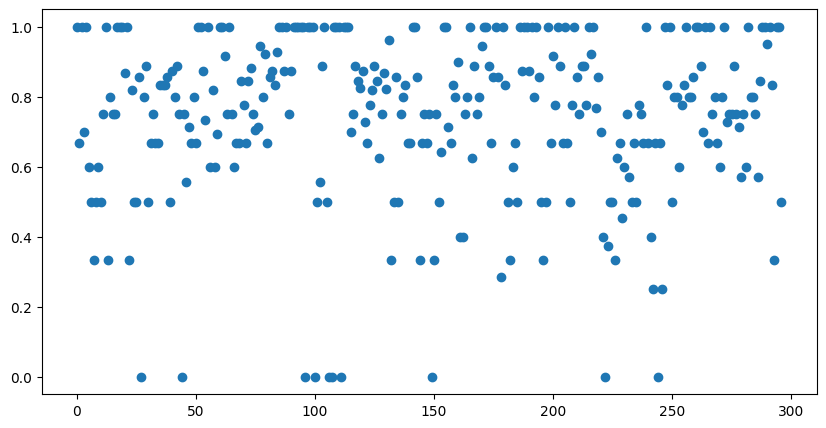

In [133]:
fig, ax = plt.subplots(figsize=(10,5))
assigned_paths_mean["path_id_new"].plot(marker="o", linestyle="None")
plt.show()

C:\Users\Marine\AppData\Local\Temp\ipykernel_12716\443772564.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trips_covered.groupby(["origin", "destination"]).apply(proportion_of_assigned_path, "path_id").values,
C:\Users\Marine\AppData\Local\Temp\ipykernel_12716\443772564.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trips_covered.groupby(["origin", "destination"]).apply(proportion_of_assigned_pat

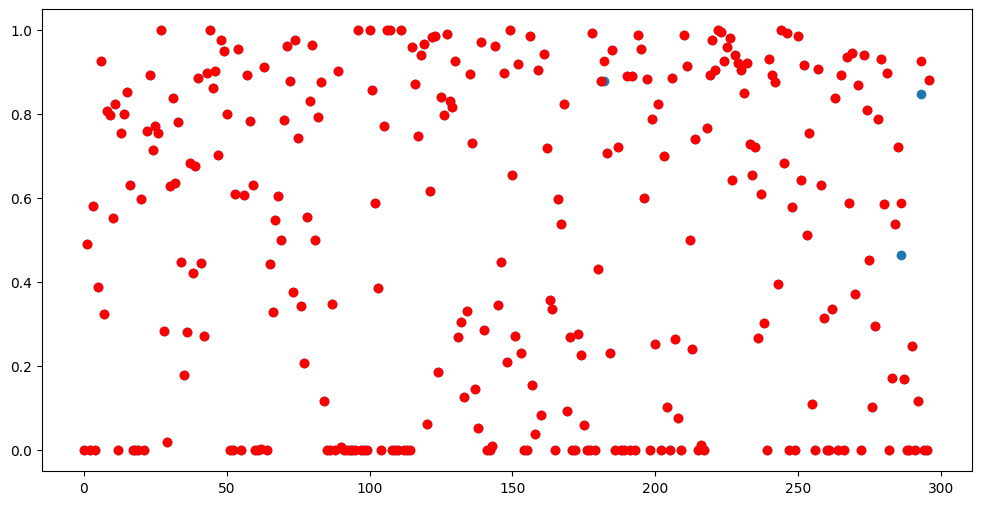

In [134]:
fig, ax = plt.subplots(figsize=(12,6))

plt.plot(
    trips_covered.groupby(["origin", "destination"]).apply(proportion_of_assigned_path, "path_id").values,
    marker="o",
    linestyle="None"
)
plt.plot(
    trips_covered.groupby(["origin", "destination"]).apply(proportion_of_assigned_path, "path_id_new").values,
    color="red",
    marker="o",
    linestyle="None"
)
plt.show()

In [135]:
trips_covered.groupby(["origin", "destination"]).apply(proportion_of_assigned_path).head()

C:\Users\Marine\AppData\Local\Temp\ipykernel_12716\2286933097.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trips_covered.groupby(["origin", "destination"]).apply(proportion_of_assigned_path).head()


origin  destination
ES111   ES114          0.000000
        ES213          0.490532
        ES243          0.000000
        ES300          0.581709
        ES418          0.000000
dtype: float64

In [136]:
trips_covered.groupby(["origin", "destination"]).apply(proportion_of_assigned_path, "path_id_new").head()

C:\Users\Marine\AppData\Local\Temp\ipykernel_12716\3885272682.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trips_covered.groupby(["origin", "destination"]).apply(proportion_of_assigned_path, "path_id_new").head()


origin  destination
ES111   ES114          0.000000
        ES213          0.490532
        ES243          0.000000
        ES300          0.581709
        ES418          0.000000
dtype: float64

In [137]:
trips_covered.groupby(["origin", "destination"])["path_id_new"].apply(lambda x:x.isnull().mean()).head()

origin  destination
ES111   ES114          1.000000
        ES213          0.666667
        ES243          1.000000
        ES300          0.700000
        ES418          1.000000
Name: path_id_new, dtype: float64

**Proportion of trips without an existing start or end pair**

In [138]:
print((trips_covered["start_exists"]).mean())
print(trips_covered[trips_covered["start_exists"]]["trips"].sum() / trips_covered["trips"].sum())

0.7173267326732673
0.9692216386000768


In [139]:
print((trips_covered["end_exists"]).mean())
print(trips_covered[trips_covered["end_exists"]]["trips"].sum() / trips_covered["trips"].sum())

0.6717821782178218
0.9612572051850915


In [140]:
print(((trips_covered["start_exists"]) & (trips_covered["end_exists"])).mean())
print(trips_covered[(trips_covered["start_exists"]) & (trips_covered["end_exists"])]["trips"].sum() / trips_covered["trips"].sum())

0.46534653465346537
0.9358112361314992


In [141]:
trips_start_end_exist = trips_covered[(trips_covered["start_exists"]) & (trips_covered["end_exists"])]

In [142]:
print("Path assigned:", round((trips_start_end_exist["path_id"]).notna().mean()*100, 2), "%")

Path assigned: 48.09 %


In [143]:
print("Passengers with assigned path:", round(proportion_of_assigned_path(trips_start_end_exist, "path_id")*100, 2), "%")
print("Passengers with assigned path new:", round(proportion_of_assigned_path(trips_start_end_exist, "path_id_new")*100, 2), "%")

Passengers with assigned path: 78.02 %
Passengers with assigned path new: 78.16 %


C:\Users\Marine\AppData\Local\Temp\ipykernel_12716\4180130428.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trips_start_end_exist.groupby(["origin", "destination"]).apply(proportion_of_assigned_path, "path_id").values,


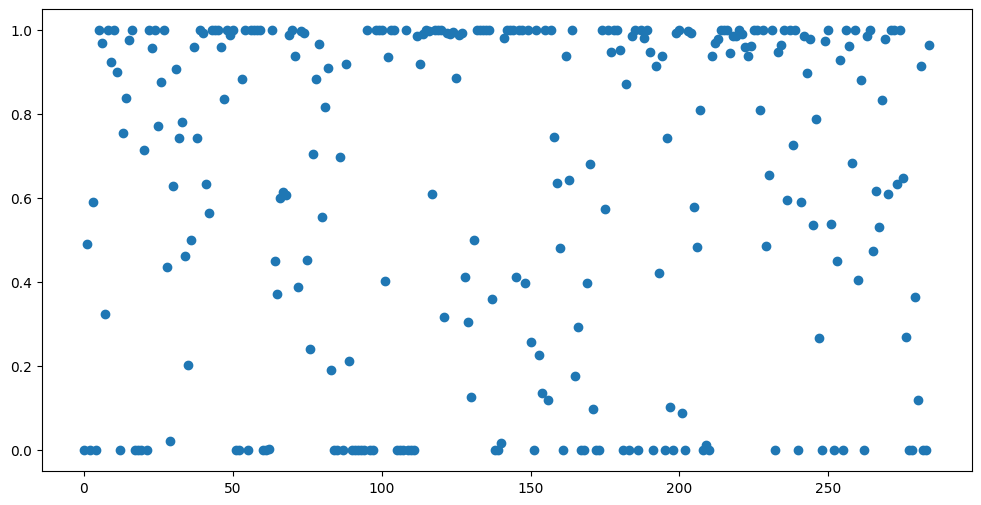

In [144]:
fig, ax = plt.subplots(figsize=(12,6))

plt.plot(
    trips_start_end_exist.groupby(["origin", "destination"]).apply(proportion_of_assigned_path, "path_id").values,
    marker="o",
    linestyle="None"
)

plt.show()

C:\Users\Marine\AppData\Local\Temp\ipykernel_12716\985747390.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trips_start_end_exist.groupby(["origin", "destination"]).apply(


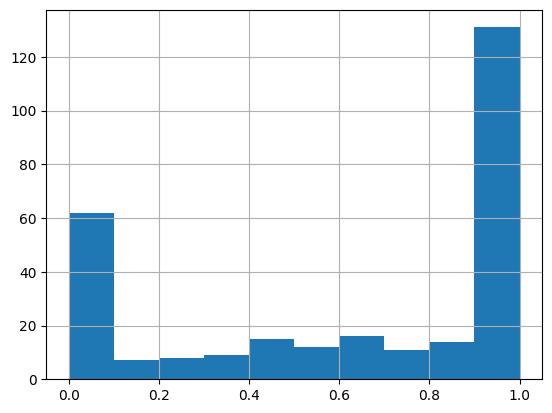

In [145]:
trips_start_end_exist.groupby(["origin", "destination"]).apply(
    proportion_of_assigned_path
).hist()
plt.show()

In [146]:
trips_covered.groupby("destination_name").apply(proportion_of_assigned_path)

C:\Users\Marine\AppData\Local\Temp\ipykernel_12716\1669314540.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trips_covered.groupby("destination_name").apply(proportion_of_assigned_path)


destination_name
A Coruña                0.292560
Alicante / Alacant      0.383330
Barcelona               0.944238
Castellón / Castelló    0.902744
Cádiz                   0.595558
Girona                  0.943640
Guadalajara             0.379981
Illes Balears           0.934253
Madrid                  0.662462
Murcia                  0.577789
Málaga                  0.779396
Pontevedra              0.150289
Sevilla                 0.756345
Tarragona               0.902857
Valencia / València     0.704617
Valladolid              0.653721
Vizcaya                 0.739006
Zaragoza                0.659992
dtype: float64

In [151]:
trips_start_end_exist.groupby("destination_name").apply(proportion_of_assigned_path)

C:\Users\Marine\AppData\Local\Temp\ipykernel_12716\1157070421.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trips_start_end_exist.groupby("destination_name").apply(proportion_of_assigned_path)


destination_name
A Coruña                0.313856
Alicante / Alacant      0.452853
Barcelona               0.985730
Castellón / Castelló    0.964706
Cádiz                   0.637252
Girona                  0.983984
Guadalajara             0.397591
Illes Balears           0.959252
Madrid                  0.698045
Murcia                  0.703230
Málaga                  0.854538
Pontevedra              0.165914
Sevilla                 0.801795
Tarragona               0.940810
Valencia / València     0.772464
Valladolid              0.847503
Vizcaya                 0.908493
Zaragoza                0.723500
dtype: float64

In [148]:
not_assigned = trips_start_end_exist[trips_start_end_exist["path_id"].isna()].sort_values("trips", ascending=False).reset_index(drop=True)

<Axes: >

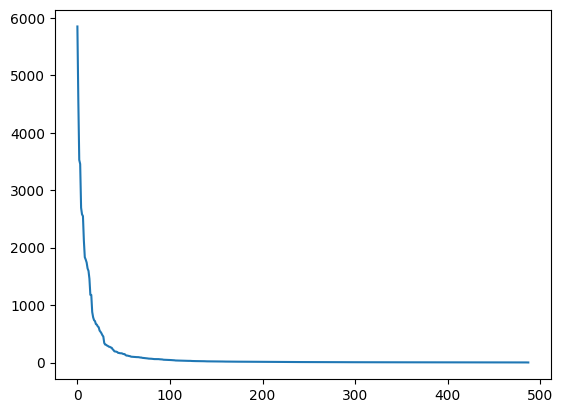

In [149]:
not_assigned["trips"].plot()

In [149]:
not_assigned.head(10)

,date,trip_period,origin_zone,origin,origin_name,destination_zone,destination,destination_name,entry_point,exit_point,origin_purpose,destination_purpose,distance,route_distance,duration,mode,service,legs,trip_vehicle_type,nationality,home_census,home_zone,overnight_census,income,age,sex,vehicle_type,short_professional_driver,trips_km,sample_trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,n_legs,mode_sequence,node_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,clean_node_sequence,clean_start_node_old,clean_end_node_old,clean_start_node,clean_end_node,path,od_path,trips,start_exists,end_exists,path_id,new_node_sequence,od_path_new,path_id_new,%_of_od
0,20220923,P04,46102,ES523,Valencia / València,2807905,ES300,Madrid,NaN,NaN,H,NF,D05_[50000-inf),D05_[50000-inf),04-06,train,conv_unknown,P04*46102*4625003*None*train_03216*01-02*road*...,other,ES,2_46,46102,2_46,I01_[10000-15000),A02_[45-65),female,passenger,False,959.539,1.0,489.534879,17.332947,26.821765,56.955014,89.892183,40.207212,3,road-train-road,train_03216-train_17000,train_03216,train_17000,national,2,1,0,train_03216-train_17000,train_3216,train_17000,[train],"[03216, 17000]",3216,17000,3216,17000,"['3216', '17000']","ES523_ES300__['3216', '17000']",720.744,True,True,NaN,"['3216', '17000']","ES523_ES300__['3216', '17000']",NaN,0.206174
1,20220923,P03,2811502,ES300,Madrid,2906709,ES617,Málaga,NaN,NaN,H,NF,D05_[50000-inf),D05_[50000-inf),06-08,plane,NaN,P03*2811502*2807921*None*airport_MAD*00-01*roa...,other,ES,2_28,2811502,2_28,I02_[15000-inf),A01_[25-45),male,passenger,False,1914.541,1.0,463.927312,14.844251,19.863314,55.381085,29.388301,30.662737,3,road-plane-road,airport_MAD-airport_AGP,airport_MAD,airport_AGP,national,2,0,1,airport_MAD-airport_AGP,airport_MAD,airport_AGP,[plane],"[MAD, AGP]",MAD,AGP,LEMD,LEMG,"['LEMD', 'LEMG']","ES300_ES617__['LEMD', 'LEMG']",614.067,True,True,NaN,"['LEMD', 'LEMG']","ES300_ES617__['LEMD', 'LEMG']",NaN,0.176509
2,20220923,P05,2905101,ES617,Málaga,2807905,ES300,Madrid,NaN,NaN,H,NF,D05_[50000-inf),D05_[50000-inf),10-inf,plane,NaN,P05*2905101*2906711*None*airport_AGP*01-02*roa...,other,ES,2_29,2905101,2_29,I01_[10000-15000),A02_[45-65),female,passenger,False,1933.290,1.0,328.857738,14.797151,16.278233,50.499747,67.853788,30.493343,3,road-plane-road,airport_AGP-airport_MAD,airport_AGP,airport_MAD,national,2,0,1,airport_AGP-airport_MAD,airport_AGP,airport_MAD,[plane],"[AGP, MAD]",AGP,MAD,LEMG,LEMD,"['LEMG', 'LEMD']","ES617_ES300__['LEMG', 'LEMD']",508.780,True,True,NaN,"['LEMG', 'LEMD']","ES617_ES300__['LEMG', 'LEMD']",NaN,0.201545
3,20220923,P04,2800504,ES300,Madrid,4622006,ES523,Valencia / València,NaN,NaN,NF,NF,D05_[50000-inf),D05_[50000-inf),04-06,train,conv_unknown,P04*2800504*2807905*None*train_17000*00-01*roa...,other,ES,2_28,2800505,2_28,I01_[10000-15000),A02_[45-65),male,passenger,False,1531.196,1.0,224.921364,8.014091,11.391715,31.095482,18.311355,18.363993,3,road-train-road,train_17000-train_03216,train_17000,train_03216,national,2,1,0,train_17000-train_03216,train_17000,train_3213,[train],"[17000, 03216]",17000,3213,17000,3216,"['17000', '3216']","ES300_ES523__['17000', '3216']",312.098,True,True,NaN,"['17000', '3216']","ES300_ES523__['17000', '3216']",NaN,0.087830
4,20220923,P00,4109106,ES618,Sevilla,2807901,ES300,Madrid,NaN,NaN,NF,NF,D05_[50000-inf),D05_[50000-inf),06-08,plane,NaN,P00*4109106*4109109*None*airport_SVQ*00-01*roa...,other,ES,2_41,41017,2_41,I01_[10000-15000),A02_[45-65),female,passenger,False,1595.380,1.0,223.321545,3.765222,6.432662,16.091241,20.041335,18.277995,3,road-plane-road,airport_SVQ-airport_MAD,airport_SVQ,airport_MAD,national,2,0,1,airport_SVQ-airport_MAD,airport_SVQ,airport_MAD,[plane],"[SVQ, MAD]",SVQ,MAD,LEZL,LEMD,"['LEZL', 'LEMD']","ES618_ES300__['LEZL', 'LEMD']",287.930,True,True,NaN,"['LEZL', 'LEMD']","ES618_ES300__['LEZL', 'LEMD']",NaN,0.115626
5,20220923,P00,2807902,ES300,Madrid,410

## Example of specific OD pairs

**ES300 to ES523, Madrid to Valencia**

In [145]:
proportion_of_assigned_path(
    trips_covered[
        (trips_covered["origin"] == "ES300") &
        (trips_covered["destination"] == "ES523")
    ])

0.8315467562023646

In [146]:
trips_covered[
    (trips_covered["origin"] == "ES300") &
    (trips_covered["destination"] == "ES523") &
    (trips_covered["start_exists"]) &
    (trips_covered["end_exists"]) 
]["trips"].sum() / trips_covered[
    (trips_covered["origin"] == "ES300") &
    (trips_covered["destination"] == "ES523")
]["trips"].sum()

0.9397451992335318

In [147]:
possible_itineraries[
    (possible_itineraries["origin"] == "ES300") &
    (possible_itineraries["destination"] == "ES523")
].shape

(30, 67)

In [148]:
possible_itineraries_reduced[
    (possible_itineraries_reduced["origin"] == "ES300") &
    (possible_itineraries_reduced["destination"] == "ES523")
].shape

(3, 70)

In [149]:
possible_itineraries_reduced[
    (possible_itineraries_reduced["origin"] == "ES300") &
    (possible_itineraries_reduced["destination"] == "ES523")
]

,origin,destination,option,nservices,path,total_travel_time,total_cost,total_emissions,total_waiting_time,nmodes,journey_type,access_time,egress_time,service_id_0,origin_0,destination_0,provider_0,alliance_0,mode_0,departure_time_0,arrival_time_0,travel_time_0,cost_0,emissions_0,service_id_1,origin_1,destination_1,provider_1,alliance_1,mode_1,departure_time_1,arrival_time_1,travel_time_1,mct_time_0_1,connecting_time_0_1,waiting_time_0_1,cost_1,emissions_1,service_id_2,origin_2,destination_2,provider_2,alliance_2,mode_2,departure_time_2,arrival_time_2,travel_time_2,mct_time_1_2,connecting_time_1_2,waiting_time_1_2,cost_2,emissions_2,service_id_3,origin_3,destination_3,provider_3,alliance_3,mode_3,departure_time_3,arrival_time_3,travel_time_3,mct_time_2_3,connecting_time_2_3,waiting_time_2_3,cost_3,emissions_3,mode_tp,od_path,path_id,num_trips
215,ES300,ES523,0,1,"['60000', '3216']",208.838333,31.77,8.73,NaN,1,rail,42.173333,66.665,0511012022-09-18_1_2,60000,3216,RENFE OPERADORA,RENFE OPERADORA,rail,2014-09-12 11:40:00,2014-09-12 13:20:00,100.0,31.77,8.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[rail],"ES300_ES523__['60000', '3216']",path_id_0_ES300_ES523,2954.854
216,ES300,ES523,17,2,"['18000', '17000', '60000', '3216']",278.006667,32.45,8.94,2.0,1,rail,43.341667,66.665,0019712022-09-23_10_11,18000,17000,RENFE OPERADORA,RENFE OPERADORA,rail,2014-09-12 11:45:00,2014-09-12 11:58:00,13.0,0.68,0.21,0650612022-07-07_1_4,60000,3216,RENFE OPERADORA,RENFE OPERADORA,rail,2014-09-12 12:40:00,2014-09-12 14:33:00,113.0,40.0,42.0,2.0,31.77,8.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[rail, rail]","ES300_ES523__['18000', '17000', '60000', '3216']",path_id_17_ES300_ES523,NaN
217,ES300,ES523,21,2,"['LEMD', 'LEIB', 'LEVC']",294.026667,228.78,73.55,25.0,1,air,45.636667,63.390,VY_3419,LEMD,LEIB,VY,VY,air,2019-09-06 09:00:00,2019-09-06 10:20:00,80.0,133.82,42.82,VY_3694,LEIB,LEVC,VY,VY,air,2019-09-06 11:15:00,2019-09-06 12:05:00,50.0,30.0,55.0,25.0,94.96,30.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[air, air]","ES300_ES523__['LEMD', 'LEIB', 'LEVC']",path_id_21_ES300_ES523,NaN


In [150]:
trips_covered[
    (trips_covered["origin"] == "ES300") &
    (trips_covered["destination"] == "ES523")
    & (trips_covered["start_exists"]) &
    (trips_covered["end_exists"]) 
].sort_values("trips", ascending=False)

,date,trip_period,origin_zone,origin,origin_name,destination_zone,destination,destination_name,entry_point,exit_point,origin_purpose,destination_purpose,distance,route_distance,duration,mode,service,legs,trip_vehicle_type,nationality,home_census,home_zone,overnight_census,income,age,sex,vehicle_type,short_professional_driver,trips_km,sample_trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,n_legs,mode_sequence,node_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,clean_node_sequence,clean_start_node_old,clean_end_node_old,clean_start_node,clean_end_node,path,od_path,trips,start_exists,end_exists,path_id,new_node_sequence,od_path_new,path_id_new,%_of_od
225,20220923,P00,28104,ES300,Madrid,46213,ES523,Valencia / València,NaN,NaN,O,H,D05_[50000-inf),D05_[50000-inf),04-06,train,conv_unknown,P00*28104*2807902*None*train_60000*00-01*road*...,other,ES,2_46,46213,2_28,I01_[10000-15000),A00_[0-25),male,long,False,2030.006,1.0,2082.948568,79.616024,106.432148,307.471997,178.323392,200.061870,3,road-train-road,train_60000-train_03213,train_60000,train_03213,national,2,1,0,train_60000-train_03213,train_60000,train_3216,[train],"[60000, 03213]",60000,3216,60000,3216,"['60000', '3216']","ES300_ES523__['60000', '3216']",2954.854,True,True,path_id_0_ES300_ES523,"['60000', '3216']","ES300_ES523__['60000', '3216']",path_id_0_ES300_ES523,0.831547
1431,20220923,P04,2800504,ES300,Madrid,4622006,ES523,Valencia / València,NaN,NaN,NF,NF,D05_[50000-inf),D05_[50000-inf),04-06,train,conv_unknown,P04*2800504*2807905*None*train_17000*00-01*roa...,other,ES,2_28,2800505,2_28,I01_[10000-15000),A02_[45-65),male,passenger,False,1531.196,1.0,224.921364,8.014091,11.391715,31.095482,18.311355,18.363993,3,road-train-road,train_17000-train_03216,train_17000,train_03216,national,2,1,0,train_17000-train_03216,train_17000,train_3213,[train],"[17000, 03216]",17000,3213,17000,3216,"['17000', '3216']","ES300_ES523__['17000', '3216']",312.098,True,True,NaN,"['17000', '3216']","ES300_ES523__['17000', '3216']",NaN,0.087830
1992,20220923,P05,28019_AM,ES300,Madrid,4625003,ES523,Valencia / València,NaN,NaN,NF,NF,D05_[50000-inf),D05_[50000-inf),03-04,plane,NaN,P05*28019_AM*2807921*None*airport_MAD*00-01*ro...,other,ES,2_03,0306507,2_28,I01_[10000-15000),A01_[25-45),male,passenger,False,854.083,1.0,45.360235,1.817827,2.456687,6.971458,4.209740,4.739054,3,road-plane-road,airport_MAD-airport_VLC,airport_MAD,airport_VLC,national,2,0,1,airport_MAD-airport_VLC,airport_MAD,airport_VLC,[plane],"[MAD, VLC]",MAD,VLC,LEMD,LEVC,"['LEMD', 'LEVC']","ES300_ES523__['LEMD', 'LEVC']",65.555,True,True,NaN,"['LEMD', 'LEVC']","ES300_ES523__['LEMD', 'LEVC']",NaN,0.018448
770,20220923,P02,28123,ES300,Madrid,4625001,ES523,Valencia / València,NaN,NaN,NF,NF,D05_[50000-inf),D05_[50000-inf),10-inf,plane,NaN,P02*28123*2807921*None*airport_MAD*00-01*road*...,other,ES,2_28,2807404,2_28,I01_[10000-15000),A02_[45-65),female,passenger,False,2300.657,1.0,2.296948,0.141787,0.137736,0.520560,0.283574,0.269395,5,road-plane-road-train-road,airport_MAD-airport_ALC-train_60911-train_65200,airport_MAD,train_65200,national,3,1,1,airport_MAD-airport_ALC-train_60911-train_65200,airport_MAD,train_65200,"[plane, train]","[MAD, ALC, 60911, 65200]",MAD,65200,LEMD,3216,"['LEMD', 'LEAL', '60911', '3216']","ES300_ES523__['LEMD', 'LEAL', '60911', '3216']",3.650,True,True,NaN,"['LEMD', 'LEAL', '60911', '3216']","ES300_ES523__['LEMD', 'LEAL', '60911', '3216']",NaN,0.001027
7414,20220923,P13,28083,ES300,Madrid,46214_AM,ES523,Valencia / València,NaN,NaN,NF,NF,D05_[50000-inf),D05_[50000-inf),10-inf,plane,NaN,P13*28083*2807921*None*airport_MAD*00-01*road*...,other,PL,NaN,NaN,NaN,NaN,NaN,NaN,passenger,False,1510.053,1.0,1.159619,0.040842,0.035007,0.185247,0.097729,0.068556,4,road-plane-plane-road,airport_MAD-airport_SVQ-airport_VLC,airport_MAD,airport_VLC,national,2,0,2,airport_MAD-airport_SVQ-airport_VLC,airport_MAD,airport_VL

**ES300 to ES521, Madrid to Alicante**

In [151]:
proportion_of_assigned_path(
    trips_covered[
        (trips_covered["origin"] == "ES300") &
        (trips_covered["destination"] == "ES521")
    ])

C:\Users\Marine\AppData\Local\Temp\ipykernel_23240\1534454315.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return assigned_path_travellers / df["trips"].sum()


nan

In [152]:
regions_access_all[regions_access_all["region"] == "ES300"]

,Unnamed: 0,region,station,layer,access_type,pax_type,avg_time,processing_time,total_time,icao_station,region_name,location_nut
256,256,ES300,LEMD,air,access,all,45.636667,90,135.636667,LEMD,Madrid,ES300
257,257,ES300,LEMD,air,egress,all,45.636667,30,75.636667,LEMD,Madrid,ES300
258,258,ES300,60000,rail,access,all,42.173333,15,57.173333,60000,Madrid,ES300
259,259,ES300,60000,rail,egress,all,42.173333,10,52.173333,60000,Madrid,ES300
260,260,ES300,17000,rail,access,all,38.131667,15,53.131667,17000,Madrid,ES300
261,261,ES300,17000,rail,egress,all,38.131667,10,48.131667,17000,Madrid,ES300
262,262,ES300,18000,rail,access,all,43.341667,15,58.341667,18000,Madrid,ES300
263,263,ES300,18000,rail,egress,all,43.341667,10,53.341667,18000,Madrid,ES300
264,264,ES300,10200,rail,access,all,55.813333,15,70.813333,10200,Madrid,ES300
265,265,ES300,10200,rail,egress,all,55.813333,10,65.813333,10200,Madrid,ES300


In [153]:
trips_covered[
    (trips_covered["origin"] == "ES300") &
    (trips_covered["destination"] == "ES521") &
    (trips_covered["start_exists"]) &
    (trips_covered["end_exists"]) 
]["trips"].sum() / trips_covered[
    (trips_covered["origin"] == "ES300") &
    (trips_covered["destination"] == "ES521")
]["trips"].sum()

C:\Users\Marine\AppData\Local\Temp\ipykernel_23240\3530335517.py:1: RuntimeWarning: invalid value encountered in scalar divide
  trips_covered[


nan

In [154]:
possible_itineraries[
    (possible_itineraries["origin"] == "ES300") &
    (possible_itineraries["destination"] == "ES521")
].shape

(0, 67)

In [160]:
possible_itineraries_reduced[
    (possible_itineraries_reduced["origin"] == "ES300") &
    (possible_itineraries_reduced["destination"] == "ES521")
].shape

(0, 70)

In [161]:
possible_itineraries_reduced[
    (possible_itineraries_reduced["origin"] == "ES300") &
    (possible_itineraries_reduced["destination"] == "ES521")
]

,origin,destination,option,nservices,path,total_travel_time,total_cost,total_emissions,total_waiting_time,nmodes,journey_type,access_time,egress_time,service_id_0,origin_0,destination_0,provider_0,alliance_0,mode_0,departure_time_0,arrival_time_0,travel_time_0,cost_0,emissions_0,service_id_1,origin_1,destination_1,provider_1,alliance_1,mode_1,departure_time_1,arrival_time_1,travel_time_1,mct_time_0_1,connecting_time_0_1,waiting_time_0_1,cost_1,emissions_1,service_id_2,origin_2,destination_2,provider_2,alliance_2,mode_2,departure_time_2,arrival_time_2,travel_time_2,mct_time_1_2,connecting_time_1_2,waiting_time_1_2,cost_2,emissions_2,service_id_3,origin_3,destination_3,provider_3,alliance_3,mode_3,departure_time_3,arrival_time_3,travel_time_3,mct_time_2_3,connecting_time_2_3,waiting_time_2_3,cost_3,emissions_3,mode_tp,od_path,path_id,num_trips


In [162]:
trips_covered[
    (trips_covered["origin"] == "ES300") &
    (trips_covered["destination"] == "ES521")
    # & (trips_covered["start_exists"]) &
    # (trips_covered["end_exists"]) 
].sort_values("trips", ascending=False)

,date,trip_period,origin_zone,origin,origin_name,destination_zone,destination,destination_name,entry_point,exit_point,origin_purpose,destination_purpose,distance,route_distance,duration,mode,service,legs,trip_vehicle_type,nationality,home_census,home_zone,overnight_census,income,age,sex,vehicle_type,short_professional_driver,trips_km,sample_trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,n_legs,mode_sequence,node_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,clean_node_sequence,clean_start_node_old,clean_end_node_old,clean_start_node,clean_end_node,path,od_path,trips,start_exists,end_exists,path_id,new_node_sequence,od_path_new,path_id_new,%_of_od


**ES300 to ES709, Madrid to Tenerife**

In [163]:
proportion_of_assigned_path(
    trips_covered[
        (trips_covered["origin"] == "ES300") &
        (trips_covered["destination"] == "ES709")
    ])

0.9413686400225324

In [164]:
regions_access_all[regions_access_all["region"] == "ES709"]

,Unnamed: 0,region,station,layer,access_type,pax_type,avg_time,processing_time,total_time,icao_station,region_name,location_nut
0,0,ES709,GCXO,air,access,all,53.438333,90,143.438333,GCXO,Santa Cruz de Tenerife,ES709
1,1,ES709,GCXO,air,egress,all,53.438333,30,83.438333,GCXO,Santa Cruz de Tenerife,ES709
2,2,ES709,GCTS,air,access,all,81.606667,90,171.606667,GCTS,Santa Cruz de Tenerife,ES709
3,3,ES709,GCTS,air,egress,all,81.606667,30,111.606667,GCTS,Santa Cruz de Tenerife,ES709
4,4,ES709,GCLA,air,access,all,274.395000,90,364.395000,GCLA,Santa Cruz de Tenerife,ES707
5,5,ES709,GCLA,air,egress,all,274.395000,30,304.395000,GCLA,Santa Cruz de Tenerife,ES707


In [165]:
trips_covered[
    (trips_covered["origin"] == "ES300") &
    (trips_covered["destination"] == "ES709") &
    (trips_covered["start_exists"]) &
    (trips_covered["end_exists"]) 
]["trips"].sum() / trips_covered[
    (trips_covered["origin"] == "ES300") &
    (trips_covered["destination"] == "ES709")
]["trips"].sum()

1.0

In [166]:
trips_covered[
    (trips_covered["origin"] == "ES300") &
    (trips_covered["destination"] == "ES709") &
    (trips_covered["start_exists"]) &
    (trips_covered["end_exists"]) 
].head()

,date,trip_period,origin_zone,origin,origin_name,destination_zone,destination,destination_name,entry_point,exit_point,origin_purpose,destination_purpose,distance,route_distance,duration,mode,service,legs,trip_vehicle_type,nationality,home_census,home_zone,overnight_census,income,age,sex,vehicle_type,short_professional_driver,trips_km,sample_trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,n_legs,mode_sequence,node_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,clean_node_sequence,clean_start_node_old,clean_end_node_old,clean_start_node,clean_end_node,path,od_path,trips,start_exists,end_exists,path_id,new_node_sequence,od_path_new,path_id_new,%_of_od
187,20220923,P00,2800702,ES300,Madrid,38035_AM,ES709,Santa Cruz de Tenerife,NaN,NaN,H,NF,D05_[50000-inf),D05_[50000-inf),02-03,plane,NaN,P00*2800702*2807921*None*airport_MAD*00-01*roa...,other,ES,2_28,2800702,2_38,I01_[10000-15000),A00_[0-25),male,passenger,False,3747.957,1.0,180.482007,7.082743,6.244796,43.160016,13.761052,15.025386,3,road-plane-road,airport_MAD-airport_TFS,airport_MAD,airport_TFS,national,2,0,1,airport_MAD-airport_TFS,airport_MAD,airport_TFS,[plane],"[MAD, TFS]",MAD,TFS,LEMD,GCTS,"['LEMD', 'GCTS']","ES300_ES709__['LEMD', 'GCTS']",265.756,True,True,path_id_1_ES300_ES709,"['LEMD', 'GCTS']","ES300_ES709__['LEMD', 'GCTS']",path_id_1_ES300_ES709,0.145061
1030,20220923,P03,2807904,ES300,Madrid,3802301,ES709,Santa Cruz de Tenerife,NaN,NaN,NF,NF,D05_[50000-inf),D05_[50000-inf),08-10,plane,NaN,P03*2807904*2807921*None*airport_MAD*01-02*roa...,other,ES,2_31,31908_AM,2_28,I01_[10000-15000),A00_[0-25),male,passenger,False,16161.531,1.0,981.812976,37.631823,34.488688,244.281067,76.872310,83.766136,3,road-plane-road,airport_MAD-airport_TFN,airport_MAD,airport_TFN,national,2,0,1,airport_MAD-airport_TFN,airport_MAD,airport_TFN,[plane],"[MAD, TFN]",MAD,TFN,LEMD,GCXO,"['LEMD', 'GCXO']","ES300_ES709__['LEMD', 'GCXO']",1458.853,True,True,path_id_0_ES300_ES709,"['LEMD', 'GCXO']","ES300_ES709__['LEMD', 'GCXO']",path_id_0_ES300_ES709,0.796307
3676,20220923,P07,28127,ES300,Madrid,38045,ES709,Santa Cruz de Tenerife,NaN,NaN,H,NF,D05_[50000-inf),D05_[50000-inf),08-10,plane,NaN,P07*28127*2807921*None*airport_MAD*01-02*road*...,other,ES,2_28,28127,2_28,I02_[15000-inf),A02_[45-65),female,passenger,False,8830.876,1.0,60.690051,2.427565,1.878192,17.736092,5.807210,5.032890,3,road-plane-road,airport_MAD-airport_SPC,airport_MAD,airport_SPC,national,2,0,1,airport_MAD-airport_SPC,airport_MAD,airport_SPC,[plane],"[MAD, SPC]",MAD,SPC,LEMD,GCLA,"['LEMD', 'GCLA']","ES300_ES709__['LEMD', 'GCLA']",93.572,True,True,NaN,"['LEMD', 'GCLA']","ES300_ES709__['LEMD', 'GCLA']",NaN,0.051076
5237,20220923,P09,2807904,ES300,Madrid,38008,ES709,Santa Cruz de Tenerife,NaN,NaN,NF,O,D05_[50000-inf),D05_[50000-inf),06-08,plane,NaN,P09*2807904*2807921*None*airport_MAD*00-01*roa...,other,ES,2_38,38039,2_28,I01_[10000-15000),A02_[45-65),male,passenger,False,5877.219,1.0,6.275889,0.213732,0.241130,1.924768,0.579651,0.693830,4,road-plane-plane-road,airport_MAD-airport_TFN-airport_SPC,airport_MAD,airport_SPC,national,2,0,2,airport_MAD-airport_TFN-airport_SPC,airport_MAD,airport_SPC,"[plane, plane]","[MAD, TFN, SPC]",MAD,SPC,LEMD,GCLA,"['LEMD', 'GCXO', 'GCLA']","ES300_ES709__['LEMD', 'GCXO', 'GCLA']",9.929,True,True,NaN,"['LEMD', 'GCXO', 'GCLA']","ES300_ES709__['LEMD', 'GCXO', 'GCLA']",NaN,0.005420
7386,20220923,P13,28002,ES300,Madrid,38012,ES709,Santa Cruz de Tenerife,NaN,NaN,O,NF,D05_[50000-inf),D05_[50000-inf),04-06,plane,NaN,P13*28002*2807921*None*airport_MAD*00-01*road*...,other,ES,2_28,2814801,2_28,I01_[10000-15000),A02_[45-65),male,passenger,False,4322.362,1.0,1.471217,0.034536,0.041443,0.379892,0.131235,0.172678,4,road-plane-plane-road,airport_MAD-airport_LPA-airport_TFN,airport_MAD,airport_TFN,national,2,0,2,airport_MAD-airport_LPA-airport_TFN,airport_MAD,airport_TFN,"[plane, plane]","[MAD, LPA, TFN]",MAD,TF

**ES523 to ES521, Valencia to Alicante**

In [167]:
proportion_of_assigned_path(
    trips_covered[
        (trips_covered["origin"] == "ES523") &
        (trips_covered["destination"] == "ES521")
    ])

C:\Users\Marine\AppData\Local\Temp\ipykernel_16484\1534454315.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return assigned_path_travellers / df["trips"].sum()


nan

In [168]:
possible_itineraries[
    (possible_itineraries["origin"] == "ES523") &
    (possible_itineraries["destination"] == "ES521")
].shape

(0, 67)

In [169]:
possible_itineraries_reduced[
    (possible_itineraries_reduced["origin"] == "ES523") &
    (possible_itineraries_reduced["destination"] == "ES521")
]

,origin,destination,option,nservices,path,total_travel_time,total_cost,total_emissions,total_waiting_time,nmodes,journey_type,access_time,egress_time,service_id_0,origin_0,destination_0,provider_0,alliance_0,mode_0,departure_time_0,arrival_time_0,travel_time_0,cost_0,emissions_0,service_id_1,origin_1,destination_1,provider_1,alliance_1,mode_1,departure_time_1,arrival_time_1,travel_time_1,mct_time_0_1,connecting_time_0_1,waiting_time_0_1,cost_1,emissions_1,service_id_2,origin_2,destination_2,provider_2,alliance_2,mode_2,departure_time_2,arrival_time_2,travel_time_2,mct_time_1_2,connecting_time_1_2,waiting_time_1_2,cost_2,emissions_2,service_id_3,origin_3,destination_3,provider_3,alliance_3,mode_3,departure_time_3,arrival_time_3,travel_time_3,mct_time_2_3,connecting_time_2_3,waiting_time_2_3,cost_3,emissions_3,mode_tp,od_path,path_id,num_trips


In [170]:
trips_reduced[
    (trips_reduced["destination"] == "ES523")
].groupby("clean_end_node")["trips"].sum().sort_values(ascending=False)[:5].sum() / trips_reduced[
    (trips_reduced["destination"] == "ES523")
].groupby("clean_end_node")["trips"].sum().sort_values(ascending=False).sum()

0.9796546016929958

In [171]:
trips_covered[
    (trips_covered["origin"] == "ES523") &
    (trips_covered["destination"] == "ES521") &
    (trips_covered["start_exists"]) &
    (trips_covered["end_exists"]) 
]["trips"].sum() / trips_covered[
    (trips_covered["origin"] == "ES523") &
    (trips_covered["destination"] == "ES521")
]["trips"].sum()

C:\Users\Marine\AppData\Local\Temp\ipykernel_16484\1017027415.py:1: RuntimeWarning: invalid value encountered in scalar divide
  trips_covered[


nan

In [172]:
trips_covered[
    (trips_covered["origin"] == "ES523") &
    (trips_covered["destination"] == "ES521")
    & (trips_covered["start_exists"]) &
    (trips_covered["end_exists"]) 
]

,date,trip_period,origin_zone,origin,origin_name,destination_zone,destination,destination_name,entry_point,exit_point,origin_purpose,destination_purpose,distance,route_distance,duration,mode,service,legs,trip_vehicle_type,nationality,home_census,home_zone,overnight_census,income,age,sex,vehicle_type,short_professional_driver,trips_km,sample_trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,n_legs,mode_sequence,node_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,clean_node_sequence,clean_start_node_old,clean_end_node_old,clean_start_node,clean_end_node,path,od_path,trips,start_exists,end_exists,path_id,new_node_sequence,od_path_new,path_id_new,%_of_od


**ES511 to ES523, Barcelona to Valencia**

In [173]:
proportion_of_assigned_path(
    trips_covered[
        (trips_covered["origin"] == "ES511") &
        (trips_covered["destination"] == "ES523")
    ])

0.7975300629523521

In [174]:
possible_itineraries_reduced[
    (possible_itineraries_reduced["origin"] == "ES511") &
    (possible_itineraries_reduced["destination"] == "ES523")
]

,origin,destination,option,nservices,path,total_travel_time,total_cost,total_emissions,total_waiting_time,nmodes,journey_type,access_time,egress_time,service_id_0,origin_0,destination_0,provider_0,alliance_0,mode_0,departure_time_0,arrival_time_0,travel_time_0,cost_0,emissions_0,service_id_1,origin_1,destination_1,provider_1,alliance_1,mode_1,departure_time_1,arrival_time_1,travel_time_1,mct_time_0_1,connecting_time_0_1,waiting_time_0_1,cost_1,emissions_1,service_id_2,origin_2,destination_2,provider_2,alliance_2,mode_2,departure_time_2,arrival_time_2,travel_time_2,mct_time_1_2,connecting_time_1_2,waiting_time_1_2,cost_2,emissions_2,service_id_3,origin_3,destination_3,provider_3,alliance_3,mode_3,departure_time_3,arrival_time_3,travel_time_3,mct_time_2_3,connecting_time_2_3,waiting_time_2_3,cost_3,emissions_3,mode_tp,od_path,path_id,num_trips
319,ES511,ES523,0,1,"['LEBL', 'LEVC']",226.916667,114.59,41.50,NaN,1,air,108.526667,63.390,VY_1314,LEBL,LEVC,VY,VY,air,2019-09-06 14:35:00,2019-09-06 15:30:00,55.0,114.59,41.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[air],"ES511_ES523__['LEBL', 'LEVC']",path_id_0_ES511_ES523,73.877
320,ES511,ES523,1,1,"['71801', '3216']",326.613333,31.87,8.76,NaN,1,rail,99.948333,66.665,0107112022-09-23_1_4,71801,3216,RENFE OPERADORA,RENFE OPERADORA,rail,2014-09-12 07:15:00,2014-09-12 09:55:00,160.0,31.87,8.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[rail],"ES511_ES523__['71801', '3216']",path_id_1_ES511_ES523,3155.524
321,ES511,ES523,3,2,"['LEBL', 'LEPA', 'LEVC']",316.916667,212.23,63.15,15.0,1,air,108.526667,63.390,UX_6073,LEBL,LEPA,UX,UX,air,2019-09-06 16:45:00,2019-09-06 17:30:00,45.0,100.29,29.98,UX_4013,LEPA,LEVC,UX,UX,air,2019-09-06 18:15:00,2019-09-06 19:10:00,55.0,30.0,45.0,15.0,111.94,33.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[air, air]","ES511_ES523__['LEBL', 'LEPA', 'LEVC']",path_id_3_ES511_ES523,NaN
322,ES511,ES523,5,2,"['LEBL', 'LEIB', 'LEVC']",356.916667,206.90,63.90,45.0,1,air,108.526667,63.390,VY_3550,LEBL,LEIB,VY,VY,air,2019-09-06 09:00:00,2019-09-06 10:00:00,60.0,111.94,33.17,VY_3694,LEIB,LEVC,VY,VY,air,2019-09-06 11:15:00,2019-09-06 12:05:00,50.0,30.0,75.0,45.0,94.96,30.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[air, air]","ES511_ES523__['LEBL', 'LEIB', 'LEVC']",path_id_5_ES511_ES523,NaN
323,ES511,ES523,7,2,"['LEBL', 'LEBB', 'LEVC']",406.916667,269.78,86.64,60.0,1,air,108.526667,63.390,VY_1432,LEBL,LEBB,VY,VY,air,2019-09-06 06:55:00,2019-09-06 08:10:00,75.0,134.64,43.20,VY_3968,LEBB,LEVC,VY,VY,air,2019-09-06 09:40:00,2019-09-06 10:50:00,70.0,30.0,90.0,60.0,135.14,43.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[air, air]","ES511_ES523__['LEBL', 'LEBB', 'LEVC']",path_id_7_ES511_ES523,NaN
324,ES511,ES523,8,2,"['LEBL', 'LECO', 'LEVC']",411.916667,329.96,122.09,15.0,1,air,108.526667,63.390,VY_1292,LEBL,LECO,VY,VY,air,2019-09-06 07:30:00,2019-09-06 09:15:00,105.0,168.54,63.58,VY_1274,LECO,LEVC,VY,VY,air,2019-09-06 10:00:00,2019-09-06 11:30:00,90.0,30.0,45.0,15.0,161.42,58.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[air, air]","ES511_ES523__['LEBL', 'LECO', 'LEVC']",path_id_8_ES511_ES523,NaN
325,ES511,ES523,10,2,"['71801', '60000', '3216']",444.613333,84.73,23.29,5.0,1,rail,99.948333,66.665,0318012022-09-18_1_2,71801,60000,RENFE OPERADORA,RENFE OPERADORA,rail,2014-09-12 18:25:00,2014-09-12 20:55:00,150.0,52.96,14.56,0541012022-09-18_1_4,60000,3216,RENFE OPERADORA,RENFE OPERADORA,rail,2014-09-12 21:10:00,2014-09-12 23:03:00,113.0,10.0,15.0,5.0,31.77,8.

In [175]:
trips_reduced[
    (trips_reduced["destination"] == "ES523")
].groupby("clean_end_node")["trips"].sum().sort_values(ascending=False)[:5].sum() / trips_reduced[
    (trips_reduced["destination"] == "ES523")
].groupby("clean_end_node")["trips"].sum().sort_values(ascending=False).sum()

0.9796546016929958

In [176]:
trips_covered[
    (trips_covered["origin"] == "ES511") &
    (trips_covered["destination"] == "ES523") &
    (trips_covered["start_exists"]) &
    (trips_covered["end_exists"]) 
]["trips"].sum() / trips_covered[
    (trips_covered["origin"] == "ES511") &
    (trips_covered["destination"] == "ES523")
]["trips"].sum()

0.8038423383275879

In [177]:
trips_covered[
    (trips_covered["origin"] == "ES511") &
    (trips_covered["destination"] == "ES523")
    & (trips_covered["start_exists"]) &
    (trips_covered["end_exists"]) 
]

,date,trip_period,origin_zone,origin,origin_name,destination_zone,destination,destination_name,entry_point,exit_point,origin_purpose,destination_purpose,distance,route_distance,duration,mode,service,legs,trip_vehicle_type,nationality,home_census,home_zone,overnight_census,income,age,sex,vehicle_type,short_professional_driver,trips_km,sample_trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,n_legs,mode_sequence,node_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,clean_node_sequence,clean_start_node_old,clean_end_node_old,clean_start_node,clean_end_node,path,od_path,trips,start_exists,end_exists,path_id,new_node_sequence,od_path_new,path_id_new,%_of_od
84,20220923,P00,08208_AM,ES511,Barcelona,4614702,ES523,Valencia / València,NaN,NaN,NF,NF,D05_[50000-inf),D05_[50000-inf),04-06,train,conv_unknown,P00*08208_AM*0801903*None*train_71801*00-01*ro...,other,ES,2_08,0807306,2_46,I01_[10000-15000),A01_[25-45),male,passenger,False,1511.502,1.0,2193.859041,114.912075,163.162887,225.677000,171.569286,286.343712,3,road-train-road,train_71801-train_65000,train_71801,train_65000,national,2,1,0,train_71801-train_65000,train_71801,train_65000,[train],"[71801, 65000]",71801,65000,71801,3216,"['71801', '3216']","ES511_ES523__['71801', '3216']",3155.524,True,True,path_id_1_ES511_ES523,"['71801', '3216']","ES511_ES523__['71801', '3216']",path_id_1_ES511_ES523,0.779285
690,20220923,P02,0809602,ES511,Barcelona,46120_AM,ES523,Valencia / València,NaN,NaN,H,NF,D05_[50000-inf),D05_[50000-inf),01-02,plane,NaN,P02*0809602*0816904*None*airport_BCN*00-01*roa...,other,ES,2_08,0809602,2_08,I01_[10000-15000),A01_[25-45),male,passenger,False,993.554,1.0,50.050052,2.477118,3.697127,5.297502,4.572065,7.783136,3,road-plane-road,airport_BCN-airport_VLC,airport_BCN,airport_VLC,national,2,0,1,airport_BCN-airport_VLC,airport_BCN,airport_VLC,[plane],"[BCN, VLC]",BCN,VLC,LEBL,LEVC,"['LEBL', 'LEVC']","ES511_ES523__['LEBL', 'LEVC']",73.877,True,True,path_id_0_ES511_ES523,"['LEBL', 'LEVC']","ES511_ES523__['LEBL', 'LEVC']",path_id_0_ES511_ES523,0.018245
927,20220923,P03,0810101,ES511,Barcelona,46199,ES523,Valencia / València,NaN,NaN,H,NF,D05_[50000-inf),D05_[50000-inf),04-06,train,conv_unknown,P03*0810101*0801903*None*train_71801*00-01*roa...,other,ES,2_08,0810101,2_08,I01_[10000-15000),A01_[25-45),female,passenger,False,1384.441,1.0,17.862615,0.932477,1.611346,1.602129,1.282850,2.268583,5,road-train-road-train-road,train_71801-train_65402-train_03216-train_65200,train_71801,train_65200,national,3,2,0,train_71801-train_65402-train_03216,train_71801,train_3213,"[train, train]","[71801, 65402, 03216]",71801,3213,71801,3216,"['71801', '65402', '3216']","ES511_ES523__['71801', '65402', '3216']",25.560,True,True,NaN,"['71801', '65402', '3216']","ES511_ES523__['71801', '65402', '3216']",NaN,0.006312


In [178]:
regions_access_all[(regions_access_all["region"] == "ES523")]

,Unnamed: 0,region,station,layer,access_type,pax_type,avg_time,processing_time,total_time,icao_station,region_name,location_nut
94,94,ES523,LEVC,air,access,all,63.390000,90,153.390000,LEVC,Valencia / València,ES523
95,95,ES523,LEVC,air,egress,all,63.390000,30,93.390000,LEVC,Valencia / València,ES523
96,96,ES523,65000,rail,access,all,68.430000,15,83.430000,65000,Valencia / València,ES523
97,97,ES523,65000,rail,egress,all,68.430000,10,78.430000,65000,Valencia / València,ES523
98,98,ES523,65200,rail,access,all,78.578333,15,93.578333,65200,Valencia / València,ES523
99,99,ES523,65200,rail,egress,all,78.578333,10,88.578333,65200,Valencia / València,ES523
100,100,ES523,3213,rail,access,all,74.061667,15,89.061667,3213,Valencia / València,ES523
101,101,ES523,3213,rail,egress,all,74.061667,10,84.061667,3213,Valencia / València,ES523
102,102,ES523,3216,rail,access,all,66.665000,15,81.665000,3216,Valencia / València,ES523
103,103,ES523,3216,rail,egress,all,66.665000,10,76.665000,3216,Valencia / València,ES523


**ES243 to ES521, Zaragoza to Alicante**

In [179]:
proportion_of_assigned_path(
    trips_covered[
        (trips_covered["origin"] == "ES243") &
        (trips_covered["destination"] == "ES521")
    ])

C:\Users\Marine\AppData\Local\Temp\ipykernel_16484\1534454315.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return assigned_path_travellers / df["trips"].sum()


nan

In [180]:
trips_covered[trips_covered["origin"] == "ES243"].groupby("clean_start_node")["trips"].sum().sort_values(ascending=False)[:3].sum() / (
    trips_covered[trips_covered["origin"] == "ES243"].groupby("clean_start_node")["trips"].sum().sort_values(ascending=False).sum()
)

0.9822926436874929

In [181]:
trips_covered[
    (trips_covered["origin"] == "ES243") &
    (trips_covered["start_exists"])
]["trips"].sum() / trips_covered[trips_covered["origin"] == "ES243"]["trips"].sum()

0.9822926436874929

In [182]:
trips_covered[trips_covered["origin"] == "ES521"].groupby("clean_start_node")["trips"].sum().sort_values(ascending=False)[:5].sum() / (
    trips_covered[trips_covered["origin"] == "ES521"].groupby("clean_start_node")["trips"].sum().sort_values(ascending=False).sum()
)

0.9985634880599548

In [183]:
possible_itineraries_reduced[
    (possible_itineraries_reduced["origin"] == "ES243") &
    (possible_itineraries_reduced["destination"] == "ES521")
]

,origin,destination,option,nservices,path,total_travel_time,total_cost,total_emissions,total_waiting_time,nmodes,journey_type,access_time,egress_time,service_id_0,origin_0,destination_0,provider_0,alliance_0,mode_0,departure_time_0,arrival_time_0,travel_time_0,cost_0,emissions_0,service_id_1,origin_1,destination_1,provider_1,alliance_1,mode_1,departure_time_1,arrival_time_1,travel_time_1,mct_time_0_1,connecting_time_0_1,waiting_time_0_1,cost_1,emissions_1,service_id_2,origin_2,destination_2,provider_2,alliance_2,mode_2,departure_time_2,arrival_time_2,travel_time_2,mct_time_1_2,connecting_time_1_2,waiting_time_1_2,cost_2,emissions_2,service_id_3,origin_3,destination_3,provider_3,alliance_3,mode_3,departure_time_3,arrival_time_3,travel_time_3,mct_time_2_3,connecting_time_2_3,waiting_time_2_3,cost_3,emissions_3,mode_tp,od_path,path_id,num_trips


In [184]:
trips_covered[
    (trips_covered["origin"] == "ES243") &
    (trips_covered["destination"] == "ES521")
]

,date,trip_period,origin_zone,origin,origin_name,destination_zone,destination,destination_name,entry_point,exit_point,origin_purpose,destination_purpose,distance,route_distance,duration,mode,service,legs,trip_vehicle_type,nationality,home_census,home_zone,overnight_census,income,age,sex,vehicle_type,short_professional_driver,trips_km,sample_trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,n_legs,mode_sequence,node_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,clean_node_sequence,clean_start_node_old,clean_end_node_old,clean_start_node,clean_end_node,path,od_path,trips,start_exists,end_exists,path_id,new_node_sequence,od_path_new,path_id_new,%_of_od


In [185]:
infra_to_nut["train_67010"]

NameError: name 'infra_to_nut' is not defined

In [ ]:
station_to_all_stations["60913"]

In [ ]:
infra_to_nut["train_60913"]

In [ ]:
regions_access_all[regions_access_all["region"] == "ES243"]

In [ ]:
regions_access_all[regions_access_all["station"] == "60000"]

In [ ]:
trips_covered[(trips_covered["origin"] == "ES243") & (trips_covered["destination"] == "ES521")].iloc[2]["legs"]

In [ ]:
trips_covered[(trips_covered["origin"] == "ES243") & (trips_covered["destination"] == "ES521")]

**ES243 to ES530, Zaragoza to Baleares**

In [ ]:
proportion_of_assigned_path(
    trips_covered[
        (trips_covered["origin"] == "ES243") &
        (trips_covered["destination"] == "ES530")
    ])

In [ ]:
potential_paths[
    (potential_paths["origin"] == "ES243") &
    (potential_paths["destination"] == "ES530")
]

In [ ]:
trips_covered[(trips_covered["origin"] == "ES243") & (trips_covered["destination"] == "ES530")].iloc[0]["legs"]

In [ ]:
trips_covered[(trips_covered["origin"] == "ES243") & (trips_covered["destination"] == "ES530")][["origin", "destination", "new_node_sequence"]]

In [ ]:
trips_covered[(trips_covered["origin"] == "ES243") & (trips_covered["destination"] == "ES530")]

In [ ]:
regions_access_all[regions_access_all["region"] == "ES243"]

**ES111 to ES120**

In [ ]:
potential_paths[
    (potential_paths["origin"] == "ES111") &
    (potential_paths["destination"] == "ES120")
]

### Exploration

In [ ]:
all_stations_trips = pd.Series([i for j in trips_small["clean_node_sequence"].apply(literal_eval) for i in j])


In [ ]:
all_full_name_stations_trips = pd.DataFrame(
    [i for j in trips.drop_duplicates("node_sequence")["node_sequence"].str.split("-") for i in j],
    columns=["full_name"]
)

In [ ]:
all_stations_trips.nunique()

In [ ]:
all_full_name_stations_trips["mode"] = all_full_name_stations_trips["full_name"].apply(lambda value: value.split("_")[0])

In [ ]:
all_full_name_stations_trips_small = all_full_name_stations_trips.drop_duplicates()

In [ ]:
all_full_name_stations_trips_small["full_name"].nunique()

In [ ]:
all_full_name_stations_trips_small["mode"].value_counts()

In [ ]:
all_stations_paths = pd.Series([i for j in potential_paths["path"].apply(literal_eval) for i in j])

In [ ]:
len(set(all_stations_trips) - set(all_stations_paths))

In [ ]:
regions_access_all[regions_access_all["station"].isin(set(all_stations_paths) - set(all_stations_trips))]

In [ ]:
set(all_stations_paths) - set(all_stations_trips)

In [ ]:
len(set(all_stations_paths).intersection(set(all_stations_trips)))

In [ ]:
regions_access_all["station"]

**Check if pair in GTFS**

In [ ]:
regions_access_all[regions_access_all["station"] == "71801"]

In [ ]:
stoptimes[stoptimes["stop_id"].isin([60911, 3216])]["trip_id"].value_counts()

In [ ]:
stoptimes[stoptimes["trip_id"] == "0110112022-08-20"][["trip_id", "arrival_time", "departure_time", "stop_id"]]

**Connections**

In [ ]:
trips_covered[
    (trips_covered["mode_tp"].astype(str) == "['train', 'train']")
    # & (trips_covered["path_id"].notna())
].sort_values("trips", ascending=False).head()

In [ ]:
trips_covered[
    (trips_covered["mode_tp"].astype(str) == "['train', 'train']") &
    (trips_covered["path_id"].notna())
]["trips"].sum() / trips_covered[
    (trips_covered["mode_tp"].astype(str) == "['train', 'train']")
]["trips"].sum()

In [ ]:
trips_covered[
    (trips_covered["mode_tp"].astype(str) == "['train', 'train']") &
    (trips_covered["path_id"].notna())
]["trips"].shape[0] / trips_covered[
    (trips_covered["mode_tp"].astype(str) == "['train', 'train']")
]["trips"].shape[0]

In [ ]:
trips_covered[
    (trips_covered["mode_tp"].astype(str) == "['train', 'train']") &
    (trips_covered["path_id"].notna())
]["trips"].shape[0]

In [ ]:
trips_covered[
    (trips_covered["mode_tp"].astype(str) == "['train', 'train']")
]["trips"].shape[0]

In [ ]:
trips_covered[
    (trips_covered["mode_tp"].astype(str) == "['plane', 'plane']")
    & (trips_covered["path_id"].notna())
].shape[0] / trips_covered[
    (trips_covered["mode_tp"].astype(str) == "['plane', 'plane']")
]["trips"].sum()

In [ ]:
trips_covered[
    (trips_covered["mode_tp"].astype(str) == "['plane', 'plane']")
    & (trips_covered["path_id"].notna())
].shape[0] / trips_covered[
    (trips_covered["mode_tp"].astype(str) == "['plane', 'plane']")
].shape[0]

### How many paths do passengers actually use

**Number of node sequences per OD pair**

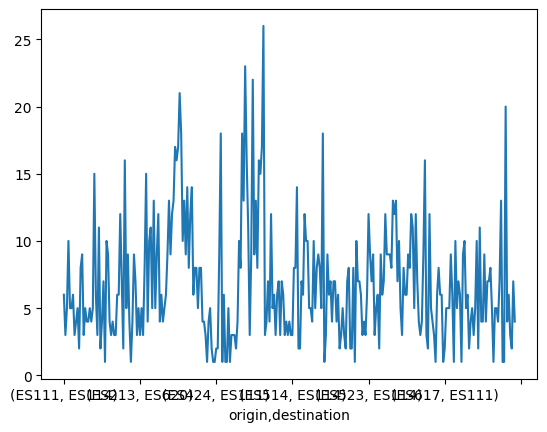

In [152]:
trips_covered.groupby(["origin", "destination"])["trips"].count().plot()
plt.show()

**Distribution of how important the path is in the OD**

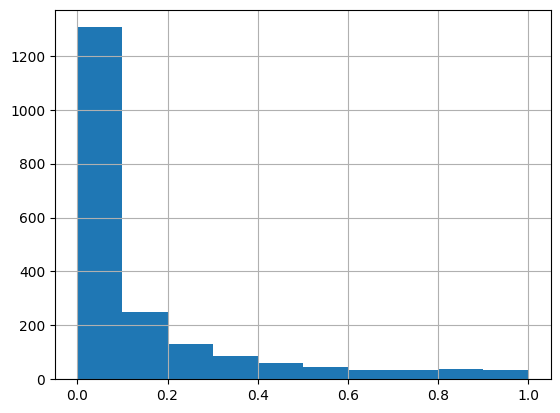

In [153]:
trips_covered["%_of_od"].hist()
plt.show()

In [154]:
trips_covered.head()

,date,trip_period,origin_zone,origin,origin_name,destination_zone,destination,destination_name,entry_point,exit_point,origin_purpose,destination_purpose,distance,route_distance,duration,mode,service,legs,trip_vehicle_type,nationality,home_census,home_zone,overnight_census,income,age,sex,vehicle_type,short_professional_driver,trips_km,sample_trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,n_legs,mode_sequence,node_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,clean_node_sequence,clean_start_node_old,clean_end_node_old,clean_start_node,clean_end_node,path,od_path,trips,start_exists,end_exists,path_id,new_node_sequence,od_path_new,path_id_new,%_of_od
14,20220923,P00,0303103,ES521,Alicante / Alacant,08086,ES511,Barcelona,NaN,NaN,NF,NF,D05_[50000-inf),D05_[50000-inf),08-10,road,NaN,P00*0303103*43904*None*train_65402*03-04*road*...,other,ES,2_03,0301801,2_03,I01_[10000-15000),A02_[45-65),male,passenger,False,1741.160,1.0,42.540917,3.347530,3.736235,7.027446,10.225286,5.715586,3,road-train-road,train_65402-train_71801,train_65402,train_71801,national,2,1,0,train_65402-train_71801,train_65402,train_71801,[train],"[65402, 71801]",65402,71801,71500,71801,"['71500', '71801']","ES521_ES511__['71500', '71801']",72.593,False,True,NaN,"['71500', '71801']","ES521_ES511__['71500', '71801']",NaN,0.088145
19,20220923,P00,0306604,ES521,Alicante / Alacant,0801904,ES511,Barcelona,NaN,NaN,H,NF,D05_[50000-inf),D05_[50000-inf),06-08,train,conv_unknown,P00*0306604*0306601*None*train_60905*00-01*roa...,other,ES,2_03,0306604,2_03,I00_[0-10000),A00_[0-25),female,passenger,False,2018.875,1.0,176.887802,14.224238,15.241900,34.261585,40.447078,28.070396,3,road-train-road,train_60905-train_71801,train_60905,train_71801,national,2,1,0,train_60905-train_71801,train_60911,train_71801,[train],"[60905, 71801]",60911,71801,60911,71801,"['60911', '71801']","ES521_ES511__['60911', '71801']",309.133,True,True,NaN,"['60911', '71801']","ES521_ES511__['60911', '71801']",NaN,0.375360
20,20220923,P00,0306604,ES521,Alicante / Alacant,2807906,ES300,Madrid,NaN,NaN,NF,W,D05_[50000-inf),D05_[50000-inf),08-10,train,conv_unknown,P00*0306604*03140*None*train_03309*00-01*road*...,other,ES,2_28,2807901,2_03,I02_[15000-inf),A02_[45-65),male,passenger,False,1443.260,1.0,869.912655,33.448888,42.019362,159.815299,285.758336,67.691460,3,road-train-road,train_03309-train_17000,train_03309,train_17000,national,2,1,0,train_03309-train_17000,train_60902,train_17000,[train],"[03309, 17000]",60902,17000,60911,17000,"['60911', '17000']","ES521_ES300__['60911', '17000']",1458.646,True,True,NaN,"['60911', '17000']","ES521_ES300__['60911', '17000']",NaN,0.569061
22,20220923,P00,0309903,ES521,Alicante / Alacant,30010,ES620,Murcia,NaN,NaN,H,O,D03_[5000-10000),D03_[5000-10000),00-01,train,conv_unknown,P00*0309903*0309902*None*train_62002*00-01*roa...,other,ES,2_03,0309903,2_03,I00_[0-10000),A00_[0-25),female,passenger,True,68.431,1.0,1891.688625,59.969134,67.979546,332.050090,188.721237,221.629368,3,road-train-road,train_62002-train_62001,train_62002,train_62001,national,2,1,0,train_62002-train_62001,train_62002,train_61200,[train],"[62002, 62001]",62002,61200,60911,61200,"['60911', '61200']","ES521_ES620__['60911', '61200']",2762.038,True,True,path_id_0_ES521_ES620,"['60911', '61200']","ES521_ES620__['60911', '61200']",path_id_0_ES521_ES620,0.879014
23,20220923,P00,0309906,ES521,Alicante / Alacant,3003003,ES620,Murcia,NaN,NaN,NF,NF,D04_[10000-50000),D04_[10000-50000),00-01,train,conv_unknown,P00*0309906*30010*None*train_62001*00-01*road*...,other,ES,2_30,3003004,2_30,I01_[10000-15000),A00_[0-25),female,passenger,False,146.166,1.0,162.764239,4.785744,5.709340,26.118766,14.869632,18.694280,3,road-train-road,train_62001-train_61200,train_62001,train_61200,national,2,1,0,train_62001,train_61200,train_61200,[train],[62001],61200,61200,61200,61200,"['61200', '61200']","ES521_ES620__['61200',

In [155]:
trips_covered["cumul_%_od"] = trips_covered.sort_values(
    ["origin", "destination", "%_of_od"], ascending=False
).groupby(["origin", "destination"])["%_of_od"].transform(lambda df: df.cumsum())

In [156]:
trips_covered["option_number"] = trips_covered.sort_values(
    ["origin", "destination", "%_of_od"], ascending=False
).groupby(["origin", "destination"])["trips"].transform(lambda df: range(1, len(df)+1))

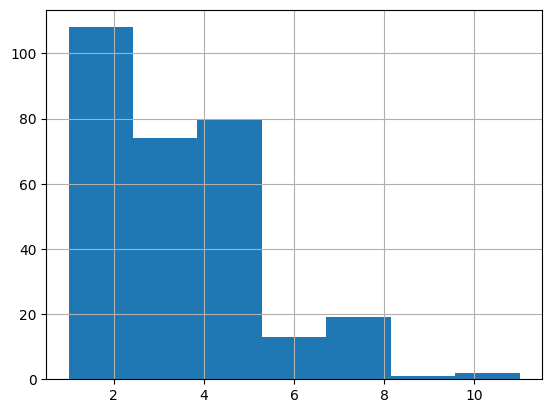

In [157]:
trips_covered[trips_covered["cumul_%_od"] > 0.9].sort_values(["origin", "destination", "cumul_%_od"]).drop_duplicates(
    ["origin", "destination"]
)["option_number"].hist(bins=7)
plt.show()

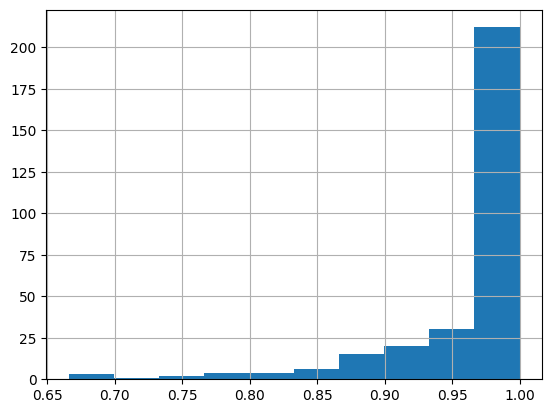

In [158]:
trips_covered[trips_covered["option_number"] <= 5].groupby(["origin", "destination"])["%_of_od"].sum().hist()
plt.show()

<Axes: >

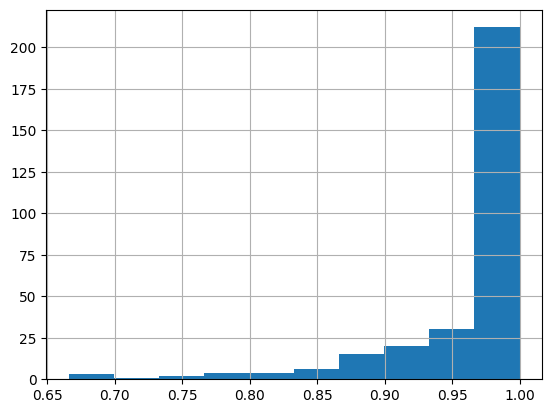

In [159]:
trips_covered[trips_covered["option_number"] <= 5].sort_values(["origin", "destination", "option_number"], ascending=False).drop_duplicates(
    ["origin", "destination"]
)["cumul_%_od"].hist()

In [160]:
trips_covered.drop_duplicates(
    ["origin", "destination"]
)[["destination"]].value_counts()

destination
ES111          17
ES114          17
ES243          17
ES300          17
ES512          17
ES511          17
ES514          17
ES523          17
ES522          17
ES521          17
ES620          17
ES530          17
ES213          16
ES418          16
ES424          16
ES618          16
ES617          15
ES612          14
Name: count, dtype: int64

## Create data formatted

**Choose OD pairs**

In [161]:
od_pair_to_proportion = trips_covered.groupby(["origin", "destination"]).apply(proportion_of_assigned_path).reset_index()

C:\Users\Marine\AppData\Local\Temp\ipykernel_12716\3318357691.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  od_pair_to_proportion = trips_covered.groupby(["origin", "destination"]).apply(proportion_of_assigned_path).reset_index()


In [162]:
od_pair_to_proportion = od_pair_to_proportion.rename(columns={0: "proportion_covered"})

In [163]:
od_pair_to_proportion

,origin,destination,proportion_covered
0,ES111,ES114,0.000000
1,ES111,ES213,0.490532
2,ES111,ES243,0.000000
3,ES111,ES300,0.581709
4,ES111,ES418,0.000000
...,...,...,...
292,ES620,ES514,0.117862
293,ES620,ES521,0.847700
294,ES620,ES522,0.000000
295,ES620,ES523,0.000000


In [164]:
lot_covered_in_3_options = trips_covered[
    (trips_covered["option_number"] == 3) & (trips_covered["cumul_%_od"] > 0.9)
][["origin", "destination"]].drop_duplicates(
    ["origin", "destination"]
)

In [165]:
to_keep = od_pair_to_proportion[
    (od_pair_to_proportion["proportion_covered"] > 0.7)
    # & (od_pair_to_proportion["proportion_covered"] <= 0.95)
]

In [166]:
od_pairs_to_keep_1 = list(zip(lot_covered_in_3_options["origin"], lot_covered_in_3_options["destination"]))

In [167]:
od_pairs_to_keep_2 = list(zip(to_keep["origin"], to_keep["destination"]))

In [168]:
print(len(set(od_pairs_to_keep_1)))
print(len(set(od_pairs_to_keep_2)))

od_pairs_to_keep = set(od_pairs_to_keep_1).intersection(set(od_pairs_to_keep_2))
print(len(od_pairs_to_keep))

145
126
93


In [169]:
trips_covered_to_keep = trips_covered[([
    a in od_pairs_to_keep for a in tuple(zip(
        trips_covered["origin"], trips_covered["destination"]
    ))
])]

In [170]:
# Out of the 1973 OD pairs in trips, we only kept the ones of the subset for trips_covered
                                                                        
trips_covered.shape

(2020, 66)

In [171]:
trips_covered_to_keep.shape

(695, 66)

In [172]:
trips_covered_to_keep[trips_covered_to_keep["path_id"].isna()]["trips"].sum() / trips_covered_to_keep["trips"].sum()

np.float64(0.060270401002770736)

**Trips to keep**

In [173]:
trips_covered_to_keep_small = trips_covered_to_keep[
    (trips_covered_to_keep["path_id"].notna()) &
    (trips_covered_to_keep["option_number"] <= 3)
]

In [174]:
paths_ids_to_keep = trips_covered_to_keep_small["path_id"].values

In [175]:
potential_paths_to_keep = potential_paths[potential_paths["path_id"].isin(paths_ids_to_keep)].copy()

In [176]:
potential_paths[potential_paths["path_id"].isin(paths_ids_to_keep)]["mode_tp"].value_counts()

mode_tp
[air]           113
[rail]           50
[rail, rail]      4
[air, air]        1
Name: count, dtype: int64

In [177]:
possible_itineraries_reduced[possible_itineraries_reduced["path_id"].isin(paths_ids_to_keep)]["mode_tp"].value_counts()

mode_tp
[air]         66
[rail]        33
[air, air]     1
Name: count, dtype: int64

In [178]:
trips_covered[trips_covered["path_id"].notna()]["mode_tp"].value_counts()

mode_tp
[plane]           262
[train]           116
[train, train]     45
[plane, plane]     22
[train, plane]      7
Name: count, dtype: int64

In [179]:
trips_covered["mode_tp"].value_counts()

mode_tp
[train]                  1075
[plane]                   524
[train, train]            212
[plane, plane]            136
[plane, train]             42
[train, plane]             22
[train, train, train]       4
[plane, plane, plane]       2
[plane, plane, train]       1
[train, plane, train]       1
[plane, train, train]       1
Name: count, dtype: int64

In [180]:
trips_covered.astype({"mode_tp": str}).groupby("mode_tp")["trips"].sum().sort_values(ascending=False)

mode_tp
['train']                      231166.855
['plane']                       58059.513
['train', 'train']               2500.127
['plane', 'plane']                992.113
['plane', 'train']                278.728
['train', 'plane']                 98.167
['train', 'train', 'train']        20.512
['plane', 'plane', 'plane']         5.660
['plane', 'plane', 'train']         4.663
['train', 'plane', 'train']         3.588
['plane', 'train', 'train']         3.418
Name: trips, dtype: float64

In [181]:
(trips_covered[trips_covered["path_id"].notna()].astype({"mode_tp": str}).groupby("mode_tp")["trips"].count()) / (
    trips_covered.astype({"mode_tp": str}).groupby("mode_tp")["trips"].count()
) 

mode_tp
['plane', 'plane', 'plane']         NaN
['plane', 'plane', 'train']         NaN
['plane', 'plane']             0.161765
['plane', 'train', 'train']         NaN
['plane', 'train']                  NaN
['plane']                      0.500000
['train', 'plane', 'train']         NaN
['train', 'plane']             0.318182
['train', 'train', 'train']         NaN
['train', 'train']             0.212264
['train']                      0.107907
Name: trips, dtype: float64

In [182]:
(trips_covered[trips_covered["path_id"].notna()].astype({"mode_tp": str}).groupby("mode_tp")["trips"].sum().sort_values(ascending=False)) / (
    trips_covered.astype({"mode_tp": str}).groupby("mode_tp")["trips"].sum().sort_values(ascending=False)
) 

mode_tp
['plane', 'plane', 'plane']         NaN
['plane', 'plane', 'train']         NaN
['plane', 'plane']             0.148071
['plane', 'train', 'train']         NaN
['plane', 'train']                  NaN
['plane']                      0.887997
['train', 'plane', 'train']         NaN
['train', 'plane']             0.275785
['train', 'train', 'train']         NaN
['train', 'train']             0.365097
['train']                      0.698103
Name: trips, dtype: float64

In [183]:
(
    trips_covered_to_keep.astype({"mode_tp": str}).groupby("mode_tp")["trips"].sum().sort_values(ascending=False) /
    trips_covered.astype({"mode_tp": str}).groupby("mode_tp")["trips"].sum().sort_values(ascending=False)
)

mode_tp
['plane', 'plane', 'plane']    0.620848
['plane', 'plane', 'train']         NaN
['plane', 'plane']             0.521994
['plane', 'train', 'train']    1.000000
['plane', 'train']             0.279631
['plane']                      0.737541
['train', 'plane', 'train']         NaN
['train', 'plane']             0.477268
['train', 'train', 'train']    0.720261
['train', 'train']             0.314624
['train']                      0.634935
Name: trips, dtype: float64

In [184]:
potential_paths[potential_paths["num_trips"].notna()]["od_path"].nunique()

452

In [185]:
trips_covered["path_id"].nunique()

452

In [186]:
trips_final = trips_covered_to_keep[
    ["path_id", "archetype_0", "archetype_1", "archetype_2", "archetype_3", "archetype_4", "archetype_5", "trips"]
]

In [187]:
trips_final_no_na = trips_final[trips_final["path_id"].notna()]

**Potential paths to keep**

In [188]:
n_alternatives = 3

In [189]:
def format_paths_for_predict(paths: pd.DataFrame, n_alternatives: int):
    paths["mode_tp"] = paths.apply(
        lambda row: [row[f"mode_{i}"] for i in range(n_alternatives) if str(row[f"mode_{i}"]) != "nan"], axis=1
    )
    paths["path_id"] = (
        "path_id_" + paths["option"].astype(str) + "_" +
        paths["origin"] + "_" + paths["destination"]
    )
    paths["option_number"] = paths.groupby(["origin", "destination"])["path_id"].transform(
        lambda df: range(1, len(df)+1)
    ).astype(str)
    paths["train"] = paths.apply(
        lambda row: "rail" in row["mode_tp"], axis=1).astype(int)
    paths["plane"] = paths.apply(
        lambda row: "air" in row["mode_tp"], axis=1).astype(int)
    paths["multimodal"] = (paths["nmodes"] > 1).astype(int)
    paths_base = paths[[
        "origin", "destination", "option_number", "path_id",
        'total_travel_time', 'total_cost', 'total_emissions',
        "multimodal", "train", "plane"
    ]].sort_values(["origin", "destination"])

    paths_pivoted = pivot_paths(paths_base)
    paths_final = paths_pivoted.groupby(["origin", "destination"]).apply(
        lambda df: df.bfill().ffill(), include_groups=False
    ).reset_index().drop_duplicates(
        ["origin", "destination", "path_id"]
    ).drop(columns=["level_2"]).fillna(0).reset_index(drop=True)

    paths_final.columns = [
        i.replace("total_", "") for i in paths_final.columns
    ]
    for i in range(1, n_alternatives+1):
        paths_final[f"av_{i}"] = (paths_final[
            f"travel_time_{i}"
        ] != 0).astype(int)

    paths_final.to_csv("paths_final.csv", header=True, index=False)

    return paths_final

In [190]:
def pivot_paths(paths: pd.DataFrame):
    paths_pivoted = paths.pivot_table(
        index=["origin", "destination", "path_id"],
        columns='option_number',
        values=[
            'total_travel_time', 'total_cost', 'total_emissions',
            "multimodal", "train", "plane"
        ],
        aggfunc='mean'
    ).reset_index()
    paths_pivoted.columns = [
        ("_".join(pair)).rstrip("_") for pair in paths_pivoted.columns
    ]
    paths_pivoted_updated = paths_pivoted.groupby(["origin", "destination"]).apply(
        assign_path_id_columns, include_groups=False).reset_index().drop(columns="level_2")
    paths_pivoted_updated["observed_choice"] = paths_pivoted_updated.groupby(["origin", "destination"])["path_id"].transform(
        lambda df: range(1, len(df)+1)
    ).astype(str)

    return paths_pivoted_updated

In [191]:
def assign_path_id_columns(df: pd.DataFrame):
    paths_ids = df["path_id"].values
    for i in range(1, len(paths_ids)+1):
        df[f"path_id_{i}"] = paths_ids[i-1]
    return df

In [192]:
paths_final = format_paths_for_predict(potential_paths_to_keep, n_alternatives)

C:\Users\Marine\AppData\Local\Temp\ipykernel_12716\553048672.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda df: df.bfill().ffill(), include_groups=False


In [218]:
format_paths_for_predict(potential_paths_to_keep, n_alternatives=3)

C:\Users\Marine\Documents\MultiModX\logit_model.py:306: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda df: df.bfill().ffill(), include_groups=False


,origin,destination,path_id,multimodal_1,multimodal_2,multimodal_3,plane_1,plane_2,plane_3,cost_1,cost_2,cost_3,emissions_1,emissions_2,emissions_3,travel_time_1,travel_time_2,travel_time_3,train_1,train_2,train_3,path_id_1,path_id_2,path_id_3,observed_choice,av_1,av_2,av_3
0,ES111,ES511,path_id_0_ES111_ES511,0.0,0.0,0.0,1.0,1.0,0.0,168.54,168.21,0.0,63.58,63.34,0.0,364.046667,380.190000,0.0,0.0,0.0,0.0,path_id_0_ES111_ES511,path_id_1_ES111_ES511,0,1,1,1,1
1,ES111,ES511,path_id_1_ES111_ES511,0.0,0.0,0.0,1.0,1.0,0.0,168.54,168.21,0.0,63.58,63.34,0.0,364.046667,380.190000,0.0,0.0,0.0,0.0,path_id_0_ES111_ES511,path_id_1_ES111_ES511,0,2,1,1,1
2,ES111,ES514,path_id_0_ES111_ES514,0.0,0.0,0.0,1.0,1.0,0.0,168.54,168.21,0.0,63.58,63.34,0.0,349.758333,365.901667,0.0,0.0,0.0,0.0,path_id_0_ES111_ES514,path_id_1_ES111_ES514,0,1,1,1,1
3,ES111,ES514,path_id_1_ES111_ES514,0.0,0.0,0.0,1.0,1.0,0.0,168.54,168.21,0.0,63.58,63.34,0.0,349.758333,365.901667,0.0,0.0,0.0,0.0,path_id_0_ES111_ES514,path_id_1_ES111_ES514,0,2,1,1,1
4,ES111,ES521,path_id_0_ES111_ES521,0.0,0.0,0.0,1.0,0.0,0.0,165.29,0.00,0.0,61.21,0.00,0.0,275.865000,0.000000,0.0,0.0,0.0,0.0,path_id_0_ES111_ES521,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,ES618,ES617,path_id_0_ES618_ES617,0.0,0.0,0.0,0.0,0.0,0.0,14.50,0.00,0.0,4.54,0.00,0.0,231.871667,0.000000,0.0,1.0,0.0,0.0,path_id_0_ES618_ES617,0,0,1,1,1,1
164,ES620,ES213,path_id_0_ES620_ES213,0.0,0.0,0.0,1.0,0.0,0.0,146.47,0.00,0.0,49.28,0.00,0.0,305.151667,0.000000,0.0,0.0,0.0,0.0,path_id_0_ES620_ES213,0,0,1,1,1,1
165,ES620,ES521,path_id_0_ES620_ES521,0.0,0.0,0.0,0.0,0.0,0.0,6.40,0.00,0.0,2.00,0.00,0.0,149.418333,0.000000,0.0,1.0,0.0,0.0,path_id_0_ES620_ES521,0,0,1,1,1,1
166,ES620,ES530,path_id_0_ES620_ES530,0.0,0.0,0.0,1.0,1.0,0.0,117.78,96.49,0.0,36.20,30.73,0.0,295.108333,487.740000,0.0,0.0,0.0,0.0,path_id_0_ES620_ES530,path_id_1_ES620_ES530,0,1,1,1,1


In [220]:
predict_main(paths_final, 6, 3, "").set_index(
        ['origin', 'destination']
).to_dict("index")

The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 4[2.0]-7[2.0]-8[2.0]-15[2.0]-16[2.0]-19[2.0]-20[2.0]-21[2.0]-22[2.0]-23[2.0]-31[2.0]-35[2.0]-39[2.0]...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 0[3.0]-1[3.0]-2[3.0]-3[3.0]-4[3.0]-5[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0...
The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 4[2.0]-7[2.0]-8[2.0]-15[2.0]-16[2.0]-19[2.0]-20[2.0]-21[2.0]-22[2.0]-23[2.0]-31[2.0]-35[2.0]-39[2.0]...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 0[3.0]-1[3.0]-2[3.0]-3[3.0]-4[3.0]-5[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0...
The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 4[2.0]-7[2.0]-8[2.0]-15[2.0]-16[2.0]-19[2.0]-20[2.0]-21[2.0]-22[2.0]-23[2.0]-31[2.0]

{('ES111', 'ES511'): {'archetype_0_prob_1': 0.508969540233594,
  'archetype_0_prob_2': 0.4910304597664047,
  'archetype_0_prob_3': 0.0,
  'archetype_1_prob_1': 0.5075804451814017,
  'archetype_1_prob_2': 0.492419554818598,
  'archetype_1_prob_3': 0.0,
  'archetype_2_prob_1': 0.5067040389436758,
  'archetype_2_prob_2': 0.49329596105632306,
  'archetype_2_prob_3': 0.0,
  'archetype_3_prob_1': 0.5066425659696601,
  'archetype_3_prob_2': 0.4933574340303406,
  'archetype_3_prob_3': 0.0,
  'archetype_4_prob_1': 0.5064374573205928,
  'archetype_4_prob_2': 0.4935625426794071,
  'archetype_4_prob_3': 0.0,
  'archetype_5_prob_1': 0.5086274324758829,
  'archetype_5_prob_2': 0.4913725675241165,
  'archetype_5_prob_3': 0.0},
 ('ES111', 'ES514'): {'archetype_0_prob_1': 0.508969540233594,
  'archetype_0_prob_2': 0.4910304597664047,
  'archetype_0_prob_3': 0.0,
  'archetype_1_prob_1': 0.5075804451814017,
  'archetype_1_prob_2': 0.492419554818598,
  'archetype_1_prob_3': 0.0,
  'archetype_2_prob_1': 0.

In [195]:
assign_passengers_main(predict_main(paths_final, 6, 3, ""), 3, demand_path)

AttributeError: Can't get attribute 'rawResults' on <module 'biogeme.results' from 'C:\\Users\\Marine\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\biogeme\\results.py'>

**Merge**

In [196]:
final_matrix = paths_final.copy()

In [197]:
for col in trips_final.columns:
    if col != "path_id":
        print(col)
        final_matrix[col] = final_matrix["path_id"].map(trips_final_no_na.set_index("path_id")[col])

archetype_0
archetype_1
archetype_2
archetype_3
archetype_4
archetype_5
trips


In [198]:
final_matrix.to_csv("calibration_matrix.csv", header=True, index=False)

In [199]:
final_matrix

,origin,destination,path_id,multimodal_1,multimodal_2,multimodal_3,plane_1,plane_2,plane_3,cost_1,cost_2,cost_3,emissions_1,emissions_2,emissions_3,travel_time_1,travel_time_2,travel_time_3,train_1,train_2,train_3,path_id_1,path_id_2,path_id_3,observed_choice,av_1,av_2,av_3,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,trips
0,ES111,ES511,path_id_0_ES111_ES511,0.0,0.0,0.0,1.0,1.0,0.0,168.54,168.21,0.0,63.58,63.34,0.0,364.046667,380.190000,0.0,0.0,0.0,0.0,path_id_0_ES111_ES511,path_id_1_ES111_ES511,0,1,1,1,0,126.695224,7.607692,9.323857,28.356338,23.302803,17.403086,212.689
1,ES111,ES511,path_id_1_ES111_ES511,0.0,0.0,0.0,1.0,1.0,0.0,168.54,168.21,0.0,63.58,63.34,0.0,364.046667,380.190000,0.0,0.0,0.0,0.0,path_id_0_ES111_ES511,path_id_1_ES111_ES511,0,2,1,1,0,215.803169,12.306803,16.378241,57.726542,43.253884,34.275360,379.744
2,ES111,ES514,path_id_0_ES111_ES514,0.0,0.0,0.0,1.0,1.0,0.0,168.54,168.21,0.0,63.58,63.34,0.0,349.758333,365.901667,0.0,0.0,0.0,0.0,path_id_0_ES111_ES514,path_id_1_ES111_ES514,0,1,1,1,0,1.740000,0.145000,0.145000,0.652500,0.145000,0.507500,3.335
3,ES111,ES514,path_id_1_ES111_ES514,0.0,0.0,0.0,1.0,1.0,0.0,168.54,168.21,0.0,63.58,63.34,0.0,349.758333,365.901667,0.0,0.0,0.0,0.0,path_id_0_ES111_ES514,path_id_1_ES111_ES514,0,2,1,1,0,13.649151,0.462296,0.096696,5.999779,1.697621,3.029457,24.935
4,ES111,ES521,path_id_0_ES111_ES521,0.0,0.0,0.0,1.0,0.0,0.0,165.29,0.00,0.0,61.21,0.00,0.0,275.865000,0.000000,0.0,0.0,0.0,0.0,path_id_0_ES111_ES521,0,0,1,1,0,0,79.183453,7.948904,5.053697,54.889593,9.502597,9.341756,165.920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,ES618,ES617,path_id_0_ES618_ES617,0.0,0.0,0.0,0.0,0.0,0.0,14.50,0.00,0.0,4.54,0.00,0.0,231.871667,0.000000,0.0,1.0,0.0,0.0,path_id_0_ES618_ES617,0,0,1,1,0,0,627.520311,19.962451,19.741116,97.147990,45.998983,64.254150,874.625
164,ES620,ES213,path_id_0_ES620_ES213,0.0,0.0,0.0,1.0,0.0,0.0,146.47,0.00,0.0,49.28,0.00,0.0,305.151667,0.000000,0.0,0.0,0.0,0.0,path_id_0_ES620_ES213,0,0,1,1,0,0,24.860365,1.213736,4.691141,1.205687,6.073148,1.422923,39.467
165,ES620,ES521,path_id_0_ES620_ES521,0.0,0.0,0.0,0.0,0.0,0.0,6.40,0.00,0.0,2.00,0.00,0.0,149.418333,0.000000,0.0,1.0,0.0,0.0,path_id_0_ES620_ES521,0,0,1,1,0,0,1727.473360,47.117491,66.520527,289.332935,150.331982,205.396704,2486.173
166,ES620,ES530,path_id_0_ES620_ES530,0.0,0.0,0.0,1.0,1.0,0.0,117.78,96.49,0.0,36.20,30.73,0.0,295.108333,487.740000,0.0,0.0,0.0,0.0,path_id_0_ES620_ES530,path_id_1_ES620_ES530,0,1,1,1,0,97.751665,5.504477,2.463360,27.211406,11.666868,12.192223,156.790


In [200]:
for i in range(1, 4):
    final_matrix[f"av_{i}"] = final_matrix[f"travel_time_{i}"].notna().astype(int)

In [201]:
final_paths = final_matrix.drop(columns=[
     "path_id", "path_id_1", "path_id_2", "path_id_3"
]).fillna(0).rename(columns={
    "total_travel_time_1": "travel_time_1",
    "total_travel_time_2": "travel_time_2",
    "total_travel_time_3": "travel_time_3",
    "total_cost_1": "cost_1",
    "total_cost_2": "cost_2",
    "total_cost_3": "cost_3",
    "total_emissions_1": "emissions_1",
    "total_emissions_2": "emissions_2",
    "total_emissions_3": "emissions_3",
})
final_paths[
    ["origin", "destination",
     "multimodal_1", "multimodal_2", "multimodal_3",
     "plane_1", "plane_2", "plane_3",
     "cost_1", "cost_2", "cost_3",
     "emissions_1", "emissions_2", "emissions_3",
     "travel_time_1", "travel_time_2", "travel_time_3",
     "train_1", "train_2", "train_3",
     "av_1", "av_2", "av_3"
]].drop_duplicates().to_csv("final_paths.csv", header=True, index=False)

In [202]:
final_matrix_reduced = final_matrix.drop(columns=[
    "origin", "destination", "path_id", "path_id_1", "path_id_2", "path_id_3"
]).fillna(0).rename(columns={
    "total_travel_time_1": "travel_time_1",
    "total_travel_time_2": "travel_time_2",
    "total_travel_time_3": "travel_time_3",
    "total_cost_1": "cost_1",
    "total_cost_2": "cost_2",
    "total_cost_3": "cost_3",
    "total_emissions_1": "emissions_1",
    "total_emissions_2": "emissions_2",
    "total_emissions_3": "emissions_3",
})
final_matrix_reduced.to_csv("calibration_matrix_reduced.csv", header=True, index=False)

In [203]:
final_matrix_reduced

,multimodal_1,multimodal_2,multimodal_3,plane_1,plane_2,plane_3,cost_1,cost_2,cost_3,emissions_1,emissions_2,emissions_3,travel_time_1,travel_time_2,travel_time_3,train_1,train_2,train_3,observed_choice,av_1,av_2,av_3,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,trips
0,0.0,0.0,0.0,1.0,1.0,0.0,168.54,168.21,0.0,63.58,63.34,0.0,364.046667,380.190000,0.0,0.0,0.0,0.0,1,1,1,1,126.695224,7.607692,9.323857,28.356338,23.302803,17.403086,212.689
1,0.0,0.0,0.0,1.0,1.0,0.0,168.54,168.21,0.0,63.58,63.34,0.0,364.046667,380.190000,0.0,0.0,0.0,0.0,2,1,1,1,215.803169,12.306803,16.378241,57.726542,43.253884,34.275360,379.744
2,0.0,0.0,0.0,1.0,1.0,0.0,168.54,168.21,0.0,63.58,63.34,0.0,349.758333,365.901667,0.0,0.0,0.0,0.0,1,1,1,1,1.740000,0.145000,0.145000,0.652500,0.145000,0.507500,3.335
3,0.0,0.0,0.0,1.0,1.0,0.0,168.54,168.21,0.0,63.58,63.34,0.0,349.758333,365.901667,0.0,0.0,0.0,0.0,2,1,1,1,13.649151,0.462296,0.096696,5.999779,1.697621,3.029457,24.935
4,0.0,0.0,0.0,1.0,0.0,0.0,165.29,0.00,0.0,61.21,0.00,0.0,275.865000,0.000000,0.0,0.0,0.0,0.0,1,1,1,1,79.183453,7.948904,5.053697,54.889593,9.502597,9.341756,165.920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.0,0.0,0.0,0.0,0.0,0.0,14.50,0.00,0.0,4.54,0.00,0.0,231.871667,0.000000,0.0,1.0,0.0,0.0,1,1,1,1,627.520311,19.962451,19.741116,97.147990,45.998983,64.254150,874.625
164,0.0,0.0,0.0,1.0,0.0,0.0,146.47,0.00,0.0,49.28,0.00,0.0,305.151667,0.000000,0.0,0.0,0.0,0.0,1,1,1,1,24.860365,1.213736,4.691141,1.205687,6.073148,1.422923,39.467
165,0.0,0.0,0.0,0.0,0.0,0.0,6.40,0.00,0.0,2.00,0.00,0.0,149.418333,0.000000,0.0,1.0,0.0,0.0,1,1,1,1,1727.473360,47.117491,66.520527,289.332935,150.331982,205.396704,2486.173
166,0.0,0.0,0.0,1.0,1.0,0.0,117.78,96.49,0.0,36.20,30.73,0.0,295.108333,487.740000,0.0,0.0,0.0,0.0,1,1,1,1,97.751665,5.504477,2.463360,27.211406,11.666868,12.192223,156.790


**Calibrate**

In [204]:
%autoreload
from logit_model import *

In [209]:
final_matrix_reduced.head()

,multimodal_1,multimodal_2,multimodal_3,plane_1,plane_2,plane_3,cost_1,cost_2,cost_3,emissions_1,emissions_2,emissions_3,travel_time_1,travel_time_2,travel_time_3,train_1,train_2,train_3,observed_choice,av_1,av_2,av_3,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,trips
0,0.0,0.0,0.0,1.0,1.0,0.0,168.54,168.21,0.0,63.58,63.34,0.0,364.046667,380.190000,0.0,0.0,0.0,0.0,1,1,1,1,126.695224,7.607692,9.323857,28.356338,23.302803,17.403086,212.689
1,0.0,0.0,0.0,1.0,1.0,0.0,168.54,168.21,0.0,63.58,63.34,0.0,364.046667,380.190000,0.0,0.0,0.0,0.0,2,1,1,1,215.803169,12.306803,16.378241,57.726542,43.253884,34.275360,379.744
2,0.0,0.0,0.0,1.0,1.0,0.0,168.54,168.21,0.0,63.58,63.34,0.0,349.758333,365.901667,0.0,0.0,0.0,0.0,1,1,1,1,1.740000,0.145000,0.145000,0.652500,0.145000,0.507500,3.335
3,0.0,0.0,0.0,1.0,1.0,0.0,168.54,168.21,0.0,63.58,63.34,0.0,349.758333,365.901667,0.0,0.0,0.0,0.0,2,1,1,1,13.649151,0.462296,0.096696,5.999779,1.697621,3.029457,24.935
4,0.0,0.0,0.0,1.0,0.0,0.0,165.29,0.00,0.0,61.21,0.00,0.0,275.865000,0.000000,0.0,0.0,0.0,0.0,1,1,1,1,79.183453,7.948904,5.053697,54.889593,9.502597,9.341756,165.920


In [219]:
calibrate_main("calibration_matrix_reduced.csv", 6, 3)

Results for model archetype_0
Nbr of parameters:		5
Sample size:			134
Excluded data:			0
Final log likelihood:		-60.73538
Akaike Information Criterion:	131.4708
Bayesian Information Criterion:	145.96

               Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  17.250773      2.152959     8.012589  1.110223e-15
ASC_TRAIN  16.328340      0.535268    30.504986  0.000000e+00
B_CO2      -0.095522      0.064003    -1.492456  1.355797e-01
B_COST      0.023143      0.027498     0.841623  3.999991e-01
B_TIME     -0.003170      0.001560    -2.032457  4.210739e-02
{'ASC_PLANE': np.float64(17.250772567892493), 'ASC_TRAIN': np.float64(16.328339571086634), 'B_CO2': np.float64(-0.09552195521548594), 'B_COST': np.float64(0.023142547722681577), 'B_TIME': np.float64(-0.0031697443013730888)}
Results for model archetype_1
Nbr of parameters:		5
Sample size:			134
Excluded data:			0
Final log likelihood:		-69.55097
Akaike Information Criterion:	149.1019
Bayesian Information Criterion:	163.5911

It seems that the optimization algorithm did not converge. Therefore, the results may not correspond to the maximum likelihood estimator. Check the specification of the model, or the criteria for convergence of the algorithm.


Results for model archetype_2
Nbr of parameters:		5
Sample size:			134
Excluded data:			0
Final log likelihood:		-64.1741
Akaike Information Criterion:	138.3482
Bayesian Information Criterion:	152.8374

               Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  16.213068      2.131710     7.605663  2.842171e-14
ASC_TRAIN  15.208448      0.489156    31.091174  0.000000e+00
B_CO2      -0.087324      0.056291    -1.551291  1.208319e-01
B_COST      0.018060      0.025469     0.709110  4.782561e-01
B_TIME     -0.002590      0.001518    -1.706186  8.797354e-02
{'ASC_PLANE': np.float64(16.21306773677016), 'ASC_TRAIN': np.float64(15.20844828733112), 'B_CO2': np.float64(-0.08732427176167577), 'B_COST': np.float64(0.01806010463114609), 'B_TIME': np.float64(-0.0025902800091639503)}
Results for model archetype_3
Nbr of parameters:		5
Sample size:			134
Excluded data:			0
Final log likelihood:		-64.1881
Akaike Information Criterion:	138.3762
Bayesian Information Criterion:	152.8654

 

It seems that the optimization algorithm did not converge. Therefore, the results may not correspond to the maximum likelihood estimator. Check the specification of the model, or the criteria for convergence of the algorithm.


Results for model archetype_5
Nbr of parameters:		5
Sample size:			134
Excluded data:			0
Final log likelihood:		-65.66913
Akaike Information Criterion:	141.3383
Bayesian Information Criterion:	155.8275

               Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  16.274572      2.104000     7.735064  1.043610e-14
ASC_TRAIN  15.452028      0.548170    28.188394  0.000000e+00
B_CO2      -0.088865      0.055253    -1.608343  1.077600e-01
B_COST      0.021513      0.024327     0.884351  3.765068e-01
B_TIME     -0.003019      0.001475    -2.047511  4.060792e-02
{'ASC_PLANE': np.float64(16.27457198617541), 'ASC_TRAIN': np.float64(15.452027803885018), 'B_CO2': np.float64(-0.08886516012237737), 'B_COST': np.float64(0.02151336724511639), 'B_TIME': np.float64(-0.0030192886197882864)}


In [ ]:
paths_probs = predict_main("final_paths.csv", 6, 3)

In [ ]:
paths_final

In [ ]:
paths_probs

In [ ]:
trips_to_compare = trips_covered_to_keep[
    ["origin", "destination", "option_number"] + list(trips_final.columns)
]

In [ ]:
trips_to_compare = trips_to_compare.drop(
    columns=["option_number", "trips"]
).reset_index(drop=True).melt(["origin", "destination", "path_id"]).rename(columns={"variable": "archetype"})

In [ ]:
trips_to_compare["alternative"] = "alternative_" + trips_to_compare["path_id"].map(
    potential_paths_to_keep.set_index("path_id")["option_number"]
)

In [ ]:
assigned_trips = assign_passengers_main(paths_probs, 3, "pax_demand.csv").drop(
    columns=["trips"]
).melt(["origin", "destination", "archetype"]).rename(columns={"variable": "alternative"})

In [ ]:
assigned_trips["key"] = (
    assigned_trips["origin"] + "_" +
    assigned_trips["destination"] + "_" +
    assigned_trips["archetype"] + "_" +
    assigned_trips["alternative"]
)

In [ ]:
trips_to_compare["key"] = (
    trips_to_compare["origin"] + "_" +
    trips_to_compare["destination"] + "_" +
    trips_to_compare["archetype"] + "_" +
    trips_to_compare["alternative"]
)

In [ ]:
assigned_trips["original_trips"] = assigned_trips["key"].map(trips_to_compare.set_index("key")["value"])

In [ ]:
assigned_trips.sort_values("key")

In [ ]:
assigned_trips["value"].corr(assigned_trips["original_trips"])

In [ ]:
plt.plot(assigned_trips["value"].values, assigned_trips["original_trips"].values, linestyle="None", marker="o")

In [ ]:
import seaborn as sns

In [ ]:
sns.lmplot(x="value", y="assigned_trips", data=trips_to_compare[trips_to_compare["assigned_trips"] < 1000])
plt.plot()

In [ ]:
from scipy import stats

In [ ]:
trips_to_compare["assigned_trips"] = trips_to_compare["key"].map(
    assigned_trips.set_index("key")["value"]
)

In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    trips_to_compare["value"], trips_to_compare["assigned_trips"]
)

In [ ]:
slope

## Format dummy data

In [ ]:
paths_final_test = pd.read_csv(r"C:\Users\Marine\Projects\MultiModX\paths_final.csv")

In [ ]:
def format_paths_for_predict(paths: pd.DataFrame, n_alternatives: int):
    paths["mode_tp"] = paths.apply(
        lambda row: [row[f"mode_{i}"] for i in range(n_alternatives) if str(row[f"mode_{i}"]) != "nan"], axis=1
    )
    paths["path_id"] = (
        "path_id_" + paths["option"].astype(str) + "_" +
        paths["origin"] + "_" + paths["destination"]
    )
    paths["option_number"] = paths.groupby(["origin", "destination"])["path_id"].transform(
        lambda df: range(1, len(df)+1)
    ).astype(str)
    paths["train"] = paths.apply(
        lambda row: "rail" in row["mode_tp"], axis=1).astype(int)
    paths["plane"] = paths.apply(
        lambda row: "air" in row["mode_tp"], axis=1).astype(int)
    paths["multimodal"] = (paths["nmodes"] > 1).astype(int)
    paths_base = paths[[
        "origin", "destination", "option_number", "path_id",
        'total_travel_time', 'total_cost', 'total_emissions',
        "multimodal", "train", "plane"
    ]].sort_values(["origin", "destination"])

    paths_pivoted = pivot_paths(paths_base)
    paths_final = paths_pivoted.groupby(["origin", "destination"]).apply(
        lambda df: df.bfill().ffill(), include_groups=False
    ).reset_index().drop_duplicates(
        ["origin", "destination", "path_id"]
    ).drop(columns=["level_2"]).fillna(0).reset_index(drop=True)

    paths_final.columns = [i.replace("total_", "")
                           for i in paths_final.columns]
    for i in range(1, n_alternatives+1):
        paths_final[f"av_{i}"] = paths_final[f"travel_time_{
            i}"].notna().astype(int)

    paths_final.to_csv("paths_final.csv", header=True, index=False)

    return paths_final


def pivot_paths(paths: pd.DataFrame):
    paths_pivoted = paths.pivot_table(
        index=["origin", "destination", "path_id"],
        columns='option_number',
        values=[
            'total_travel_time', 'total_cost', 'total_emissions',
            "multimodal", "train", "plane"
        ],
        aggfunc='mean'
    ).reset_index()
    paths_pivoted.columns = [("_".join(pair)).rstrip("_")
                             for pair in paths_pivoted.columns]
    print(paths_pivoted.columns)
    paths_pivoted_updated = paths_pivoted.groupby(["origin", "destination"]).apply(
        assign_path_id_columns, include_groups=False).reset_index().drop(columns="level_2")
    print(paths_pivoted_updated.columns)
    paths_pivoted_updated["observed_choice"] = paths_pivoted_updated.groupby(["origin", "destination"])["path_id"].transform(
        lambda df: range(1, len(df)+1)
    ).astype(str)

    return paths_pivoted_updated


def assign_path_id_columns(df: pd.DataFrame):
    paths_ids = df["path_id"].values
    for i in range(1, len(paths_ids)+1):
        df[f"path_id_{i}"] = paths_ids[i-1]
    return df


In [ ]:
format_paths_for_predict(potential_paths_covered, 3)

In [ ]:
potential_paths_test = potential_paths_covered[25:35].copy()

In [ ]:
def select_paths(paths: pd.DataFrame, n_alternatives: int):
    paths_no_duplicates = paths[~paths[["origin", "destination", "path"]].astype(str).duplicated()]
    paths_filtered = paths_no_duplicates.groupby(
        ["origin", "destination"], as_index=False
    ).apply(lambda x: x.iloc[:n_alternatives]).reset_index(level=0, drop=True)
    print("cols paths filtered", paths_filtered.columns)
    return paths_filtered

In [ ]:
potential_paths_selected = select_paths(potential_paths, n_alternatives)

In [ ]:
potential_paths_raw_test = potential_paths_selected[25:35].copy()

In [ ]:
potential_paths_selected

In [ ]:
k = format_paths_for_predict(potential_paths_raw_test, 3)

In [ ]:
predict_main(k, n_alternatives=3, n_archetypes=6)

## Investigation

In [224]:
df_itineraries_filtered = pd.read_csv(
    r"C:\Users\Marine\Projects\MultiModX\data\es_full_AW\processed\paths_itineraries\possible_itineraries_clustered_pareto_filtered_0.csv"
)

In [225]:
df_itineraries_filtered.groupby(["origin", "destination", "cluster_id"])["mode_0"].nunique().max()

np.int64(1)

In [238]:
print(read_results)


Results for model archetype_0
Nbr of parameters:		5
Sample size:			134
Excluded data:			0
Init log likelihood:		-147.214
Final log likelihood:		-60.73538
Likelihood ratio test (init):		172.9573
Rho square (init):			0.587
Rho bar square (init):			0.553
Akaike Information Criterion:	131.4708
Bayesian Information Criterion:	145.96
Final gradient norm:		7.180883e-05
ASC_PLANE      : 17.3[192 0.09 0.928][2.15 8.01 1.11e-15]
ASC_TRAIN      : 16.3[192 0.0852 0.932][0.535 30.5 0]
B_CO2          : -0.0955[0.0694 -1.38 0.169][0.064 -1.49 0.136]
B_COST         : 0.0231[0.0315 0.734 0.463][0.0275 0.842 0.4]
B_TIME         : -0.00317[0.00158 -2.01 0.0442][0.00156 -2.03 0.0421]
('ASC_TRAIN', 'ASC_PLANE'):	3.67e+04	1	-0.429	0.668	0.838	0.727	-0.512	0.609
('B_CO2', 'ASC_PLANE'):	-0.046	-0.00346	-0.0905	0.928	-0.025	-0.181	-8.01	1.11e-15
('B_CO2', 'ASC_TRAIN'):	0.00128	9.61e-05	-0.0857	0.932	0.00185	0.054	-30.7	0
('B_COST', 'ASC_PLANE'):	-0.0425	-0.00703	-0.0899	0.928	-0.0291	-0.491	-7.95	1.78e-15
('B

In [232]:
df_itineraries_filtered.groupby(["origin", "destination", "path"])["cluster_id"].nunique().head(30)

origin  destination  path                             
ES111   ES213        ['LECO', 'LEBB']                     1
        ES243        ['LECO', 'LEMD', '60000', '4040']    1
        ES300        ['LECO', 'LEMD']                     1
        ES418        ['LECO', 'LEMD']                     1
        ES424        ['LECO', 'LEMD']                     1
        ES511        ['LECO', 'LEBL']                     2
        ES512        ['LECO', 'LEBL']                     2
        ES514        ['LECO', 'LEBL']                     2
        ES521        ['LEST', 'LEAL']                     1
        ES522        ['LECO', 'LEVC']                     1
        ES523        ['LECO', 'LEVC']                     1
        ES530        ['LECO', 'LEVC', 'LEPA']             1
        ES612        ['LECO', 'LEZL']                     1
                     ['LEST', 'LEZL']                     1
        ES617        ['LECO', 'LEMG']                     1
                     ['LEST', 'LEMG']        

In [235]:
df_itineraries_filtered[(df_itineraries_filtered["origin"] == "ES111") & (df_itineraries_filtered["destination"] == "ES511")]

,origin,destination,option,nservices,path,total_travel_time,total_cost,total_emissions,total_waiting_time,nmodes,journey_type_x,access_time,egress_time,service_id_0,origin_0,destination_0,provider_0,alliance_0,mode_0,departure_time_0,arrival_time_0,travel_time_0,cost_0,emissions_0,service_id_1,origin_1,destination_1,provider_1,alliance_1,mode_1,departure_time_1,arrival_time_1,travel_time_1,mct_time_0_1,connecting_time_0_1,waiting_time_0_1,cost_1,emissions_1,service_id_2,origin_2,destination_2,provider_2,alliance_2,mode_2,departure_time_2,arrival_time_2,travel_time_2,mct_time_1_2,connecting_time_1_2,waiting_time_1_2,cost_2,emissions_2,service_id_3,origin_3,destination_3,provider_3,alliance_3,mode_3,departure_time_3,arrival_time_3,travel_time_3,mct_time_2_3,connecting_time_2_3,waiting_time_2_3,cost_3,emissions_3,journey_type_y,cluster_id
9,ES111,ES511,0,1,"['LECO', 'LEBL']",364.046667,168.54,63.58,0.0,1,air,120.52,138.526667,VY_1293,LECO,LEBL,VY,VY,air,2019-09-06 05:00:00+00:00,2019-09-06 06:45:00+00:00,105.0,168.54,63.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,air,0
10,ES111,ES511,1,1,"['LECO', 'LEBL']",364.046667,168.54,61.10,0.0,1,air,120.52,138.526667,VY_1295,LECO,LEBL,VY,VY,air,2019-09-06 15:55:00+00:00,2019-09-06 17:40:00+00:00,105.0,168.54,61.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,air,1
11,ES111,ES511,2,1,"['LECO', 'LEBL']",364.046667,168.54,63.58,0.0,1,air,120.52,138.526667,VY_1291,LECO,LEBL,VY,VY,air,2019-09-06 20:25:00+00:00,2019-09-06 22:10:00+00:00,105.0,168.54,63.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,air,0


In [226]:
df_itineraries_filtered.groupby(["origin", "destination", "cluster_id"])["path"].nunique().max()

np.int64(4)

In [14]:
df_itineraries_filtered.groupby(["origin", "destination"])["option"].nunique().max()

45

In [19]:
selected_regions_for_partial_demand = trips["origin_nut"].value_counts().index[1:21]

In [237]:
final_matrix_reduced

,multimodal_1,multimodal_2,multimodal_3,plane_1,plane_2,plane_3,cost_1,cost_2,cost_3,emissions_1,emissions_2,emissions_3,travel_time_1,travel_time_2,travel_time_3,train_1,train_2,train_3,observed_choice,av_1,av_2,av_3,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,trips
0,0.0,0.0,0.0,1.0,1.0,0.0,168.54,168.21,0.0,63.58,63.34,0.0,364.046667,380.190000,0.0,0.0,0.0,0.0,1,1,1,1,126.695224,7.607692,9.323857,28.356338,23.302803,17.403086,212.689
1,0.0,0.0,0.0,1.0,1.0,0.0,168.54,168.21,0.0,63.58,63.34,0.0,364.046667,380.190000,0.0,0.0,0.0,0.0,2,1,1,1,215.803169,12.306803,16.378241,57.726542,43.253884,34.275360,379.744
2,0.0,0.0,0.0,1.0,1.0,0.0,168.54,168.21,0.0,63.58,63.34,0.0,349.758333,365.901667,0.0,0.0,0.0,0.0,1,1,1,1,1.740000,0.145000,0.145000,0.652500,0.145000,0.507500,3.335
3,0.0,0.0,0.0,1.0,1.0,0.0,168.54,168.21,0.0,63.58,63.34,0.0,349.758333,365.901667,0.0,0.0,0.0,0.0,2,1,1,1,13.649151,0.462296,0.096696,5.999779,1.697621,3.029457,24.935
4,0.0,0.0,0.0,1.0,0.0,0.0,165.29,0.00,0.0,61.21,0.00,0.0,275.865000,0.000000,0.0,0.0,0.0,0.0,1,1,1,1,79.183453,7.948904,5.053697,54.889593,9.502597,9.341756,165.920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.0,0.0,0.0,0.0,0.0,0.0,14.50,0.00,0.0,4.54,0.00,0.0,231.871667,0.000000,0.0,1.0,0.0,0.0,1,1,1,1,627.520311,19.962451,19.741116,97.147990,45.998983,64.254150,874.625
164,0.0,0.0,0.0,1.0,0.0,0.0,146.47,0.00,0.0,49.28,0.00,0.0,305.151667,0.000000,0.0,0.0,0.0,0.0,1,1,1,1,24.860365,1.213736,4.691141,1.205687,6.073148,1.422923,39.467
165,0.0,0.0,0.0,0.0,0.0,0.0,6.40,0.00,0.0,2.00,0.00,0.0,149.418333,0.000000,0.0,1.0,0.0,0.0,1,1,1,1,1727.473360,47.117491,66.520527,289.332935,150.331982,205.396704,2486.173
166,0.0,0.0,0.0,1.0,1.0,0.0,117.78,96.49,0.0,36.20,30.73,0.0,295.108333,487.740000,0.0,0.0,0.0,0.0,1,1,1,1,97.751665,5.504477,2.463360,27.211406,11.666868,12.192223,156.790


In [275]:
pd.read_csv(r"C:\Users\Marine\Projects\MultiModX\paths_final.csv")["path_id"].value_counts()

path_id
path_id_4_ES709_ES707    1
path_id_0_ES111_ES213    1
path_id_0_ES111_ES243    1
path_id_1_ES111_ES243    1
path_id_0_ES111_ES300    1
                        ..
path_id_0_ES111_ES514    1
path_id_2_ES111_ES512    1
path_id_1_ES111_ES512    1
path_id_0_ES111_ES512    1
path_id_2_ES111_ES511    1
Name: count, Length: 1947, dtype: int64

## Analyze the final itinerary assignment

In [13]:
pax_demand_paths = pd.read_csv(
    r"C:\Users\Marine\Projects\MultiModX\data\es_full_AW\processed\paths_demand\pax_demand_paths.csv"
)

In [43]:
itineraries_clustered_final = pd.read_csv(
    r"C:\Users\Marine\Projects\MultiModX\data\es_full_AW\processed\paths_itineraries\possible_itineraries_clustered_pareto_filtered_0.csv"
)

In [48]:
paths_final = pd.read_csv(
    r"C:\Users\Marine\Projects\MultiModX\data\es_full_AW\processed\paths_demand\paths_pivoted_final.csv"
)

In [44]:
itineraries_clustered_final

,origin,destination,option,nservices,path,total_travel_time,total_cost,total_emissions,total_waiting_time,nmodes,journey_type_x,access_time,egress_time,service_id_0,origin_0,destination_0,provider_0,alliance_0,mode_0,departure_time_0,arrival_time_0,travel_time_0,cost_0,emissions_0,service_id_1,origin_1,destination_1,provider_1,alliance_1,mode_1,departure_time_1,arrival_time_1,travel_time_1,mct_time_0_1,connecting_time_0_1,waiting_time_0_1,cost_1,emissions_1,service_id_2,origin_2,destination_2,provider_2,alliance_2,mode_2,departure_time_2,arrival_time_2,travel_time_2,mct_time_1_2,connecting_time_1_2,waiting_time_1_2,cost_2,emissions_2,service_id_3,origin_3,destination_3,provider_3,alliance_3,mode_3,departure_time_3,arrival_time_3,travel_time_3,mct_time_2_3,connecting_time_2_3,waiting_time_2_3,cost_3,emissions_3,journey_type_y,cluster_id
0,ES111,ES114,2,2,"['LECO', 'LEMD', 'LEVX']",488.580000,272.90,101.99,26.0,1,air,120.520000,93.060,UX_7234,LECO,LEMD,UX,UX,air,2019-09-06 10:25:00+00:00,2019-09-06 11:35:00+00:00,70.0,138.57,43.70,IB_534,LEMD,LEVX,IB,IB,air,2019-09-06 13:45:00+00:00,2019-09-06 15:00:00+00:00,75.0,104.0,130.0,26.0,134.33,58.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,air,2
1,ES111,ES114,3,2,"['LECO', 'LEMD', 'LEVX']",503.580000,272.90,119.75,36.0,1,air,120.520000,93.060,IB_523,LECO,LEMD,IB,IB,air,2019-09-06 15:35:00+00:00,2019-09-06 16:55:00+00:00,80.0,138.57,61.46,IB_536,LEMD,LEVX,IB,IB,air,2019-09-06 19:15:00+00:00,2019-09-06 20:25:00+00:00,70.0,104.0,140.0,36.0,134.33,58.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,air,3
2,ES111,ES114,4,2,"['LECO', 'LEMD', 'LEVX']",598.580000,272.90,104.52,131.0,1,air,120.520000,93.060,IB_511,LECO,LEMD,IB,IB,air,2019-09-06 04:30:00+00:00,2019-09-06 05:50:00+00:00,80.0,138.57,61.46,IB_532,LEMD,LEVX,IB,IB,air,2019-09-06 09:45:00+00:00,2019-09-06 10:55:00+00:00,70.0,104.0,235.0,131.0,134.33,43.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,air,2
3,ES111,ES114,7,2,"['LECO', 'LEMD', 'LEVX']",723.580000,272.90,86.76,261.0,1,air,120.520000,93.060,UX_7234,LECO,LEMD,UX,UX,air,2019-09-06 10:25:00+00:00,2019-09-06 11:35:00+00:00,70.0,138.57,43.70,IB_538,LEMD,LEVX,IB,IB,air,2019-09-06 17:40:00+00:00,2019-09-06 18:55:00+00:00,75.0,104.0,365.0,261.0,134.33,43.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,air,7
4,ES111,ES213,0,1,"['LECO', 'LEBB']",236.375000,132.17,42.06,0.0,1,air,120.520000,50.855,VY_1471,LECO,LEBB,VY,VY,air,2019-09-06 15:40:00+00:00,2019-09-06 16:45:00+00:00,65.0,132.17,42.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,air,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3725,ES709,ES707,28,1,"['GCXO', 'GCLP']",501.878333,81.66,44.37,0.0,1,air,143.438333,328.440,NT_122,GCXO,GCLP,NT,NT,air,2019-09-06 20:30:00+00:00,2019-09-06 21:00:00+00:00,30.0,81.66,44.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,air,12
3726,ES709,ES707,29,1,"['GCXO', 'GCLP']",501.878333,81.66,44.37,0.0,1,air,143.438333,328.440,NT_190,GCXO,GCLP,NT,NT,air,2019-09-06 21:00:00+00:00,2019-09-06 21:30:00+00:00,30.0,81.66,44.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,air,12
3727,ES709,ES707,30,1,"['GCTS', 'GCLP']",535.046667,82.93,44.37,0.0,1,

In [49]:
od_observed_choice_to_path_id = paths_final.set_index(["origin", "destination", "observed_choice"])["path_id"].to_dict()

In [50]:
k = pax_demand_paths.drop(columns=["trips"]).melt(["origin", "destination", "archetype"])

In [51]:
k["observed_choice"] = k["variable"].str.split("_").apply(lambda l: l[-1]).astype(int)

In [52]:
k["path_id"] = k.set_index(["origin", "destination", "observed_choice"]).index.map(od_observed_choice_to_path_id)

In [53]:
path_id_to_total_passengers = k[k["path_id"].notna()].groupby("path_id")["value"].sum()

In [54]:
paths_final["total_passengers"] = paths_final["path_id"].map(path_id_to_total_passengers)

In [56]:
paths_clusters["path_id"] = (
            "cluster_id_" + paths_clusters["cluster_id"].astype(str) + "_" +
            paths_clusters["origin"] + "_" + paths_clusters["destination"]
        )

In [57]:
paths_clusters["total_passengers"] = paths_clusters["path_id"].map(path_id_to_total_passengers)

In [60]:
paths_clusters.groupby("journey_type")["total_passengers"].sum() / paths_clusters["total_passengers"].sum()

journey_type
air           0.321417
multimodal    0.046746
rail          0.631837
Name: total_passengers, dtype: float64

In [55]:
(
    pd.to_datetime(itineraries_clustered_final["arrival_time_0"]) - pd.to_datetime(itineraries_clustered_final["departure_time_0"])
).max()

Timedelta('0 days 08:25:00')

In [20]:
itineraries_luis = pd.read_csv(r"C:\Users\Marine\Downloads\possible_itineraries_clustered_pareto_filtered_0.csv")

In [24]:
itineraries_luis["total_waiting_time"].max()

np.float64(810.0)

In [34]:
itineraries_marine.shape

(1947, 68)

In [35]:
itineraries_clustered_final.shape

(3730, 68)

In [16]:
itineraries_marine_pj = pd.read_csv(r"C:\Users\Marine\Downloads\possible_itineraries_clustered_pareto_filtered_0 (2).csv")

In [17]:
itineraries_marine_pj.shape

(1947, 68)

In [19]:
itineraries_marine_pj["total_waiting_time"].max()

np.float64(1602020.0)

In [44]:
itineraries_clustered_final["total_waiting_time"].max()

np.float64(435.0)

In [21]:
itineraries_luis.shape

(28492, 68)

In [23]:
itineraries_clustered_final

,origin,destination,option,nservices,path,total_travel_time,total_cost,total_emissions,total_waiting_time,nmodes,journey_type_x,access_time,egress_time,service_id_0,origin_0,destination_0,provider_0,alliance_0,mode_0,departure_time_0,arrival_time_0,travel_time_0,cost_0,emissions_0,service_id_1,origin_1,destination_1,provider_1,alliance_1,mode_1,departure_time_1,arrival_time_1,travel_time_1,mct_time_0_1,connecting_time_0_1,waiting_time_0_1,cost_1,emissions_1,service_id_2,origin_2,destination_2,provider_2,alliance_2,mode_2,departure_time_2,arrival_time_2,travel_time_2,mct_time_1_2,connecting_time_1_2,waiting_time_1_2,cost_2,emissions_2,service_id_3,origin_3,destination_3,provider_3,alliance_3,mode_3,departure_time_3,arrival_time_3,travel_time_3,mct_time_2_3,connecting_time_2_3,waiting_time_2_3,cost_3,emissions_3,journey_type_y,cluster_id
0,ES111,ES213,0,1,"['LECO', 'LEBB']",236.375000,132.17,42.06,0.0,1,air,120.520000,50.855,VY_1471,LECO,LEBB,VY,VY,air,2019-09-06 15:40:00+00:00,2019-09-06 16:45:00+00:00,65.0,132.17,42.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,air,0
1,ES111,ES243,4,2,"['LECO', 'LEMD', '60000', '4040']",432.185000,163.72,53.83,20.0,2,multimodal,120.520000,46.665,IB_519,LECO,LEMD,IB,IB,air,2019-09-06 07:20:00+00:00,2019-09-06 08:40:00+00:00,80.0,138.57,45.95,0312312022-09-18_1_2,60000,4040,RENFE OPERADORA,RENFE OPERADORA,rail,2019-09-06 10:30:00+00:00,2019-09-06 11:45:00+00:00,75.0,90.0,110.0,20.0,25.15,7.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,multimodal,4
2,ES111,ES243,5,2,"['LECO', 'LEMD', '60000', '4040']",432.185000,163.72,53.83,20.0,2,multimodal,120.520000,46.665,IB_519,LECO,LEMD,IB,IB,air,2019-09-06 07:20:00+00:00,2019-09-06 08:40:00+00:00,80.0,138.57,45.95,0312312022-09-18_1_2,60000,4040,RENFE OPERADORA,RENFE OPERADORA,rail,2019-09-06 10:30:00+00:00,2019-09-06 11:45:00+00:00,75.0,90.0,110.0,20.0,25.15,7.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,multimodal,4
3,ES111,ES243,6,2,"['LECO', 'LEMD', '60000', '4040']",433.185000,163.72,51.58,25.0,2,multimodal,120.520000,46.665,UX_7234,LECO,LEMD,UX,UX,air,2019-09-06 10:25:00+00:00,2019-09-06 11:35:00+00:00,70.0,138.57,43.70,0315312022-09-18_1_3,60000,4040,RENFE OPERADORA,RENFE OPERADORA,rail,2019-09-06 13:30:00+00:00,2019-09-06 14:51:00+00:00,81.0,90.0,115.0,25.0,25.15,7.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,multimodal,4
4,ES111,ES243,7,2,"['LECO', 'LEMD', '60000', '4040']",433.185000,163.72,51.58,25.0,2,multimodal,120.520000,46.665,UX_7234,LECO,LEMD,UX,UX,air,2019-09-06 10:25:00+00:00,2019-09-06 11:35:00+00:00,70.0,138.57,43.70,0315312022-09-18_1_3,60000,4040,RENFE OPERADORA,RENFE OPERADORA,rail,2019-09-06 13:30:00+00:00,2019-09-06 14:51:00+00:00,81.0,90.0,115.0,25.0,25.15,7.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,multimodal,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4144,ES709,ES707,28,1,"['GCXO', 'GCLP']",501.878333,81.66,44.37,0.0,1,air,143.438333,328.440,NT_122,GCXO,GCLP,NT,NT,air,2019-09-06 20:30:00+00:00,2019-09-06 21:00:00+00:00,30.0,81.66,44.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,air,12
4145,ES709,ES707,29,1,"['GCXO', 'GCLP']",501.878333,81.66,44.37,0.0,1,air,143.438333,328.440,NT_190,GCXO,GCLP,NT,NT,air,2019-09-06 21:00:00+00:00,2019-09-06 21:30:00+00:00,30.0,81.66,44.37,NaN,

In [37]:
itineraries_clustered_final[
    (itineraries_clustered_final["origin"] == "ES300") &
    (itineraries_clustered_final["destination"] == "ES530")
]["cluster_id"].value_counts()

cluster_id
109    69
0      65
68     36
621    32
118    10
Name: count, dtype: int64

In [36]:
itineraries_luis[
    (itineraries_luis["origin"] == "ES300") &
    (itineraries_luis["destination"] == "ES530")
]["path"].value_counts()

path
['18000', '17000', 'LEMD', 'LEPA']             53
['17000', '18000', 'LEMD', 'LEPA']             29
['10200', '17000', 'LEMD', 'LEPA']             16
['LEMD', 'LEPA']                               13
['10200', '18000', '17000', 'LEMD', 'LEPA']     8
['10200', '17000', '18000', 'LEMD', 'LEPA']     6
['10200', '18000', 'LEMD', 'LEPA']              5
Name: count, dtype: int64

In [38]:
paths_clusters = pd.read_csv(r"C:\Users\Marine\Projects\MultiModX\data\es_full_AW\processed\paths_itineraries\possible_itineraries_clustered_pareto_0.csv")

In [42]:
paths_clusters.groupby(["origin", "destination"])["cluster_id"].count().value_counts()

cluster_id
2    134
1    127
3     65
4     25
5     11
7      3
8      2
6      1
9      1
Name: count, dtype: int64

In [46]:
pax_demand_paths = pd.read_csv(r"C:\Users\Marine\Projects\MultiModX\data\es_full_AW\processed\paths_demand\pax_demand_paths.csv")

In [47]:
pax_demand_paths

,origin,destination,archetype,trips,alternative_1,alternative_2,alternative_3,alternative_4,alternative_5,alternative_6,alternative_7,alternative_8,alternative_9
0,ES111,ES114,archetype_0,4361.562918,4361.562918,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,ES111,ES213,archetype_0,109.183354,109.183354,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,ES111,ES243,archetype_0,15.164822,15.164822,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,ES111,ES300,archetype_0,1323.011474,1323.011474,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,ES111,ES418,archetype_0,19.750590,19.750590,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2221,ES709,ES612,archetype_5,12.912426,6.445635,6.466792,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2222,ES709,ES617,archetype_5,29.157533,29.157533,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2223,ES709,ES618,archetype_5,38.257839,38.257839,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2224,ES709,ES620,archetype_5,13.109658,6.706539,6.403119,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
